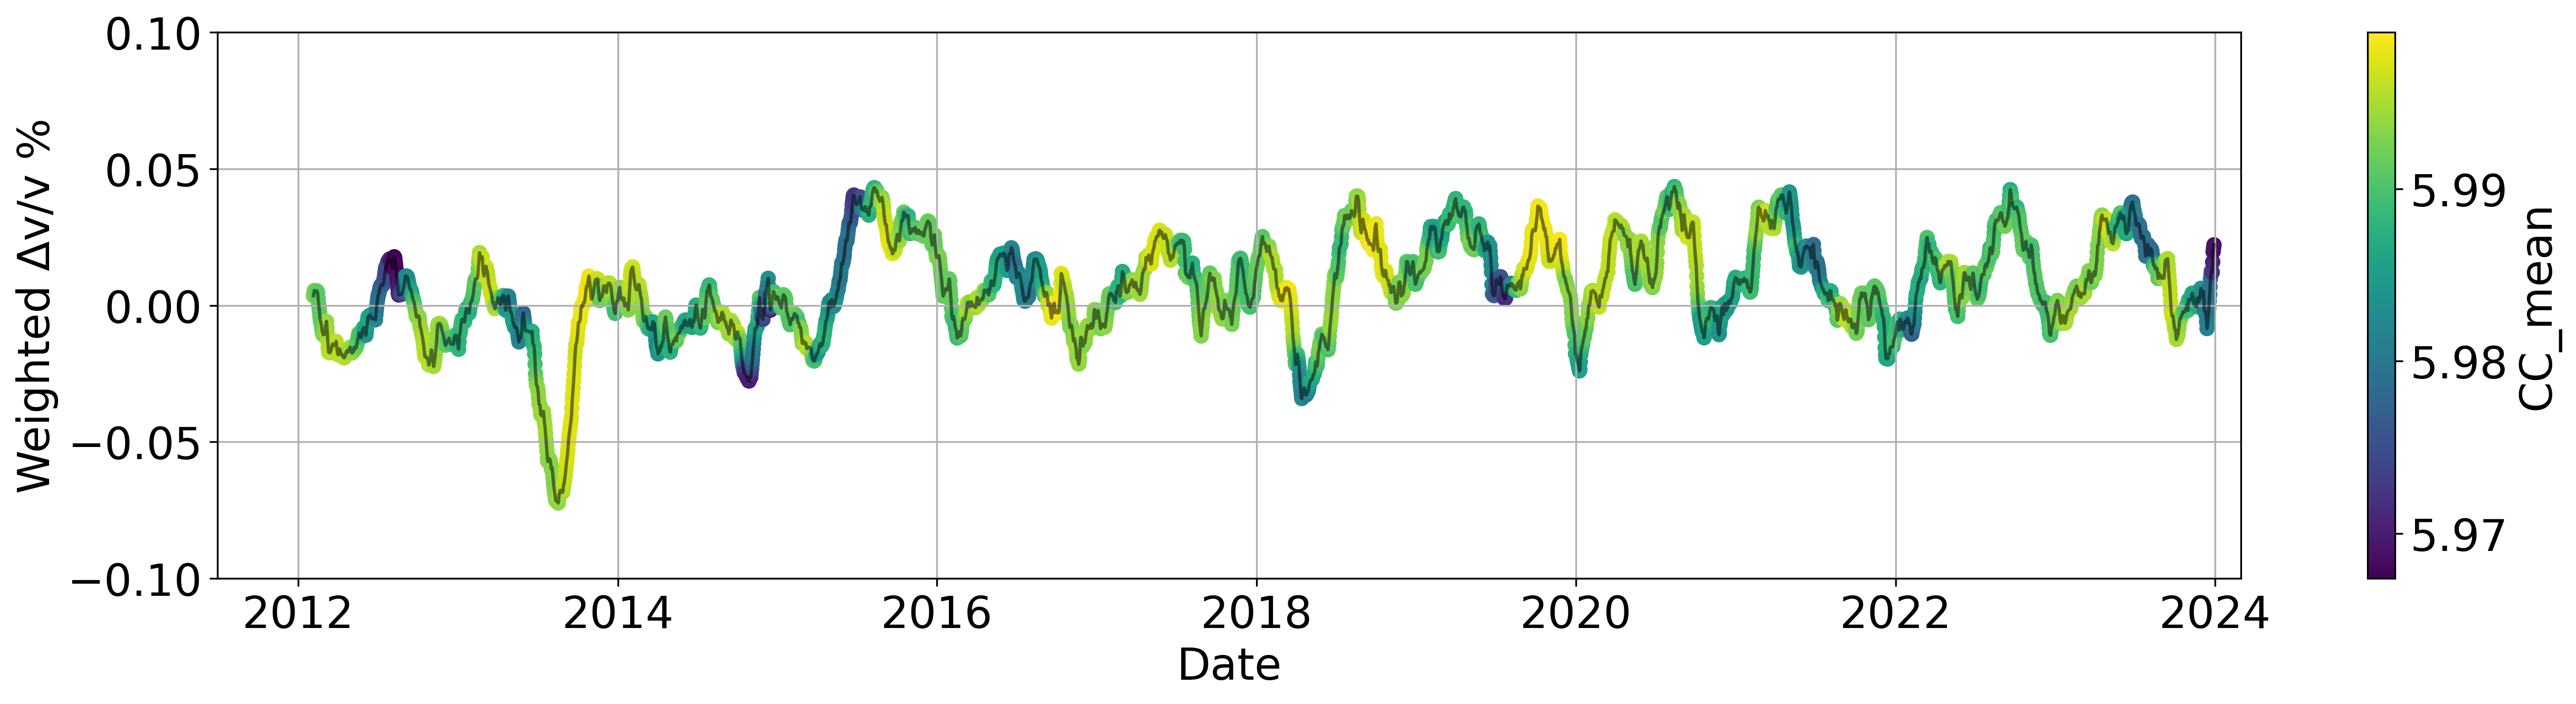

In [46]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd

# Define the paths to your CSV files
file_paths = [
    'NC89 Results/89_60daystack_0p5to1p0 positiveNZ 1025svd7.csv',
    'NC89 Results/89_60daystack_0p5to1p0 negativeNZ 2510svd7.csv',
    'NC89 Results/89_60daystack_0p5to1p0 positiveNE 1025svd7.csv',
    'NC89 Results/89_60daystack_0p5to1p0 negativeNE 2510svd7.csv',
    'NC89 Results/89_60daystack_0p5to1p0 positiveZE 1025svd7.csv',
    'NC89 Results/89_60daystack_0p5to1p0 negativeZE 2510svd7.csv',
]

dataframes = []
for path in file_paths:
    df = pd.read_csv(path)
    dataframes.append(df)

# Parse timestamps and set them as the index
for df in dataframes:
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)

# Create a daily time index from the earliest to the latest date across all dataframes
daily_index = pd.date_range(start=min(df.index.min() for df in dataframes), 
                            end=max(df.index.max() for df in dataframes), freq='D')

# Interpolate data for each dataframe to match the daily index
interpolated_dfs = [df.reindex(daily_index).interpolate() for df in dataframes]

# Define the date ranges to exclude
exclude_ranges = [
    (pd.to_datetime("2023-12-01"), pd.to_datetime("2024-01-30")),
    (pd.to_datetime("2009-11-10"), pd.to_datetime("2012-01-05"))
]

# Exclude the specified date ranges
for start_date, end_date in exclude_ranges:
    for i in range(len(interpolated_dfs)):
        interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)

# Calculate CC_mean using squared correlation coefficients for each time point
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)

# Calculate weighted Δu/u using squared CCT and DVT
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Normalize CC_mean for coloring
norm = mcolors.Normalize(vmin=CC_mean.min(), vmax=CC_mean.max())
cmap = cm.viridis  # Can choose any available colormap

# Create a DataFrame for the weighted Δv/v time series
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])

weighted_dvv_df.index = weighted_dvv_df.index + pd.DateOffset(days=30)

# Plotting the weighted Δv/v time series with color-coded CC_mean
plt.figure(figsize=(18, 5), dpi=300)
# Scatter plot for individual markers with color coding
sc = plt.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cmap, norm=norm, label='Weighted Δv/v')
# Line plot to connect markers
plt.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)  # Adjust alpha for line transparency
plt.colorbar(sc, label='CC_mean')

#plt.title('Weighted Δv/v For HYS14 1.0-3.0Hz Combined')
plt.xlabel('Date')
plt.ylim([-0.1, 0.1])
plt.ylabel('Weighted Δv/v %')
plt.grid(True)

cleaned_df = weighted_dvv_df.dropna(subset=['Weighted Δv/v'])

# Convert index to int64
index_as_int = cleaned_df.index.astype(np.int64)

start_date = pd.to_datetime("2011-07-01")
end_date = pd.to_datetime("2024-03-01")
plt.rcParams.update({'font.size': 25})
plt.xlim([start_date, end_date])
plt.xticks()
plt.tight_layout()
plt.show()


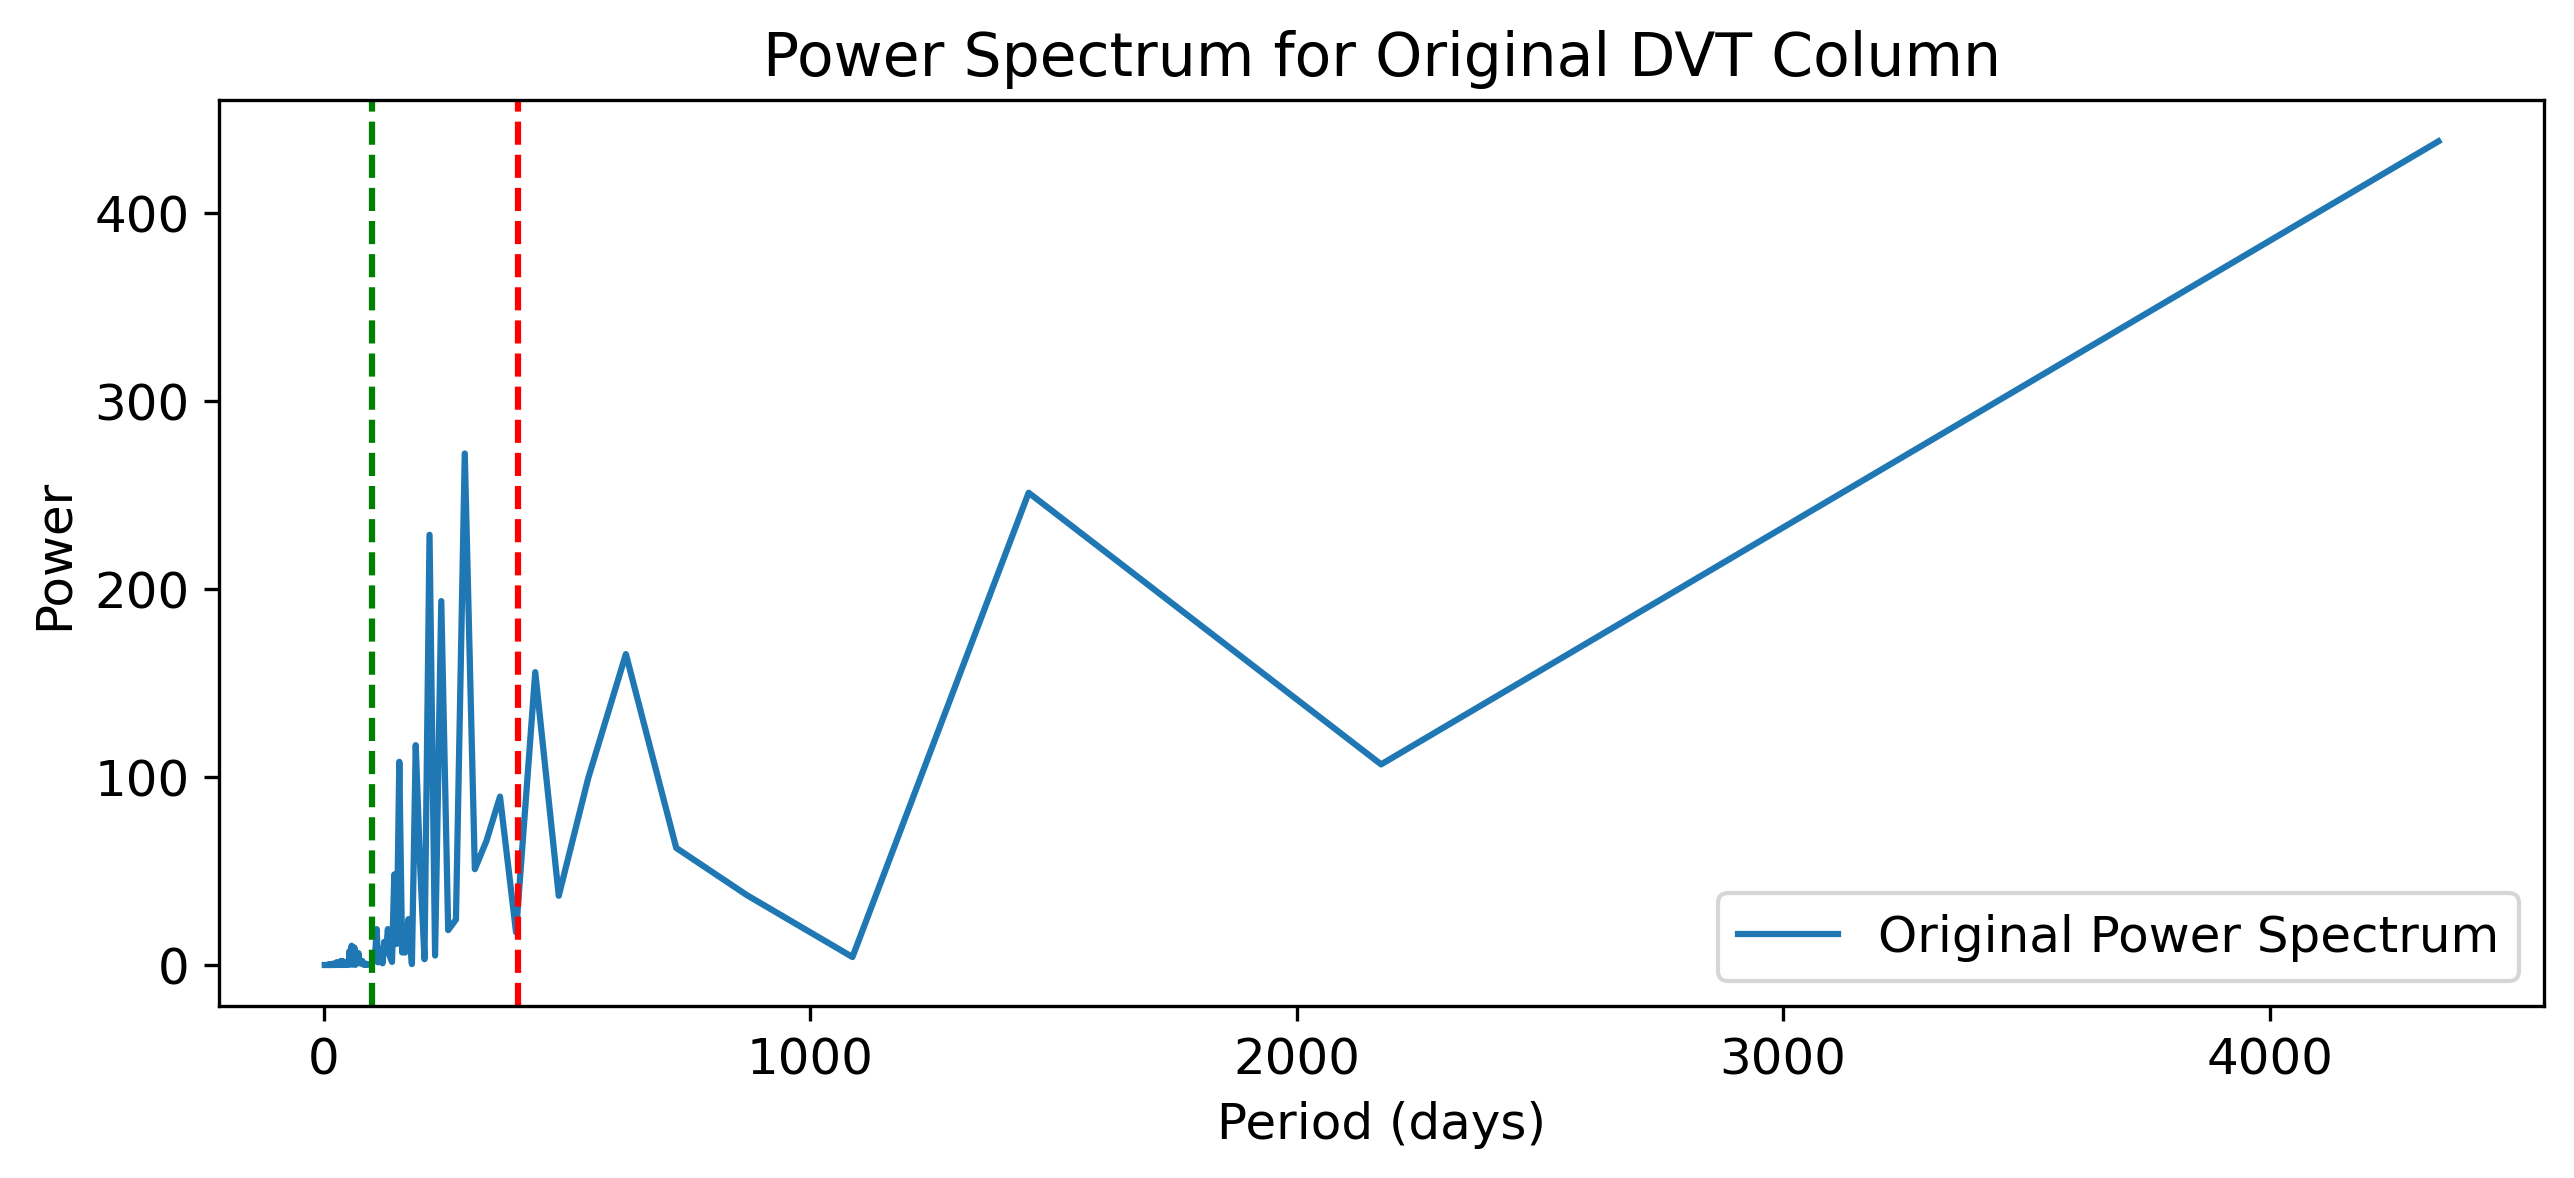

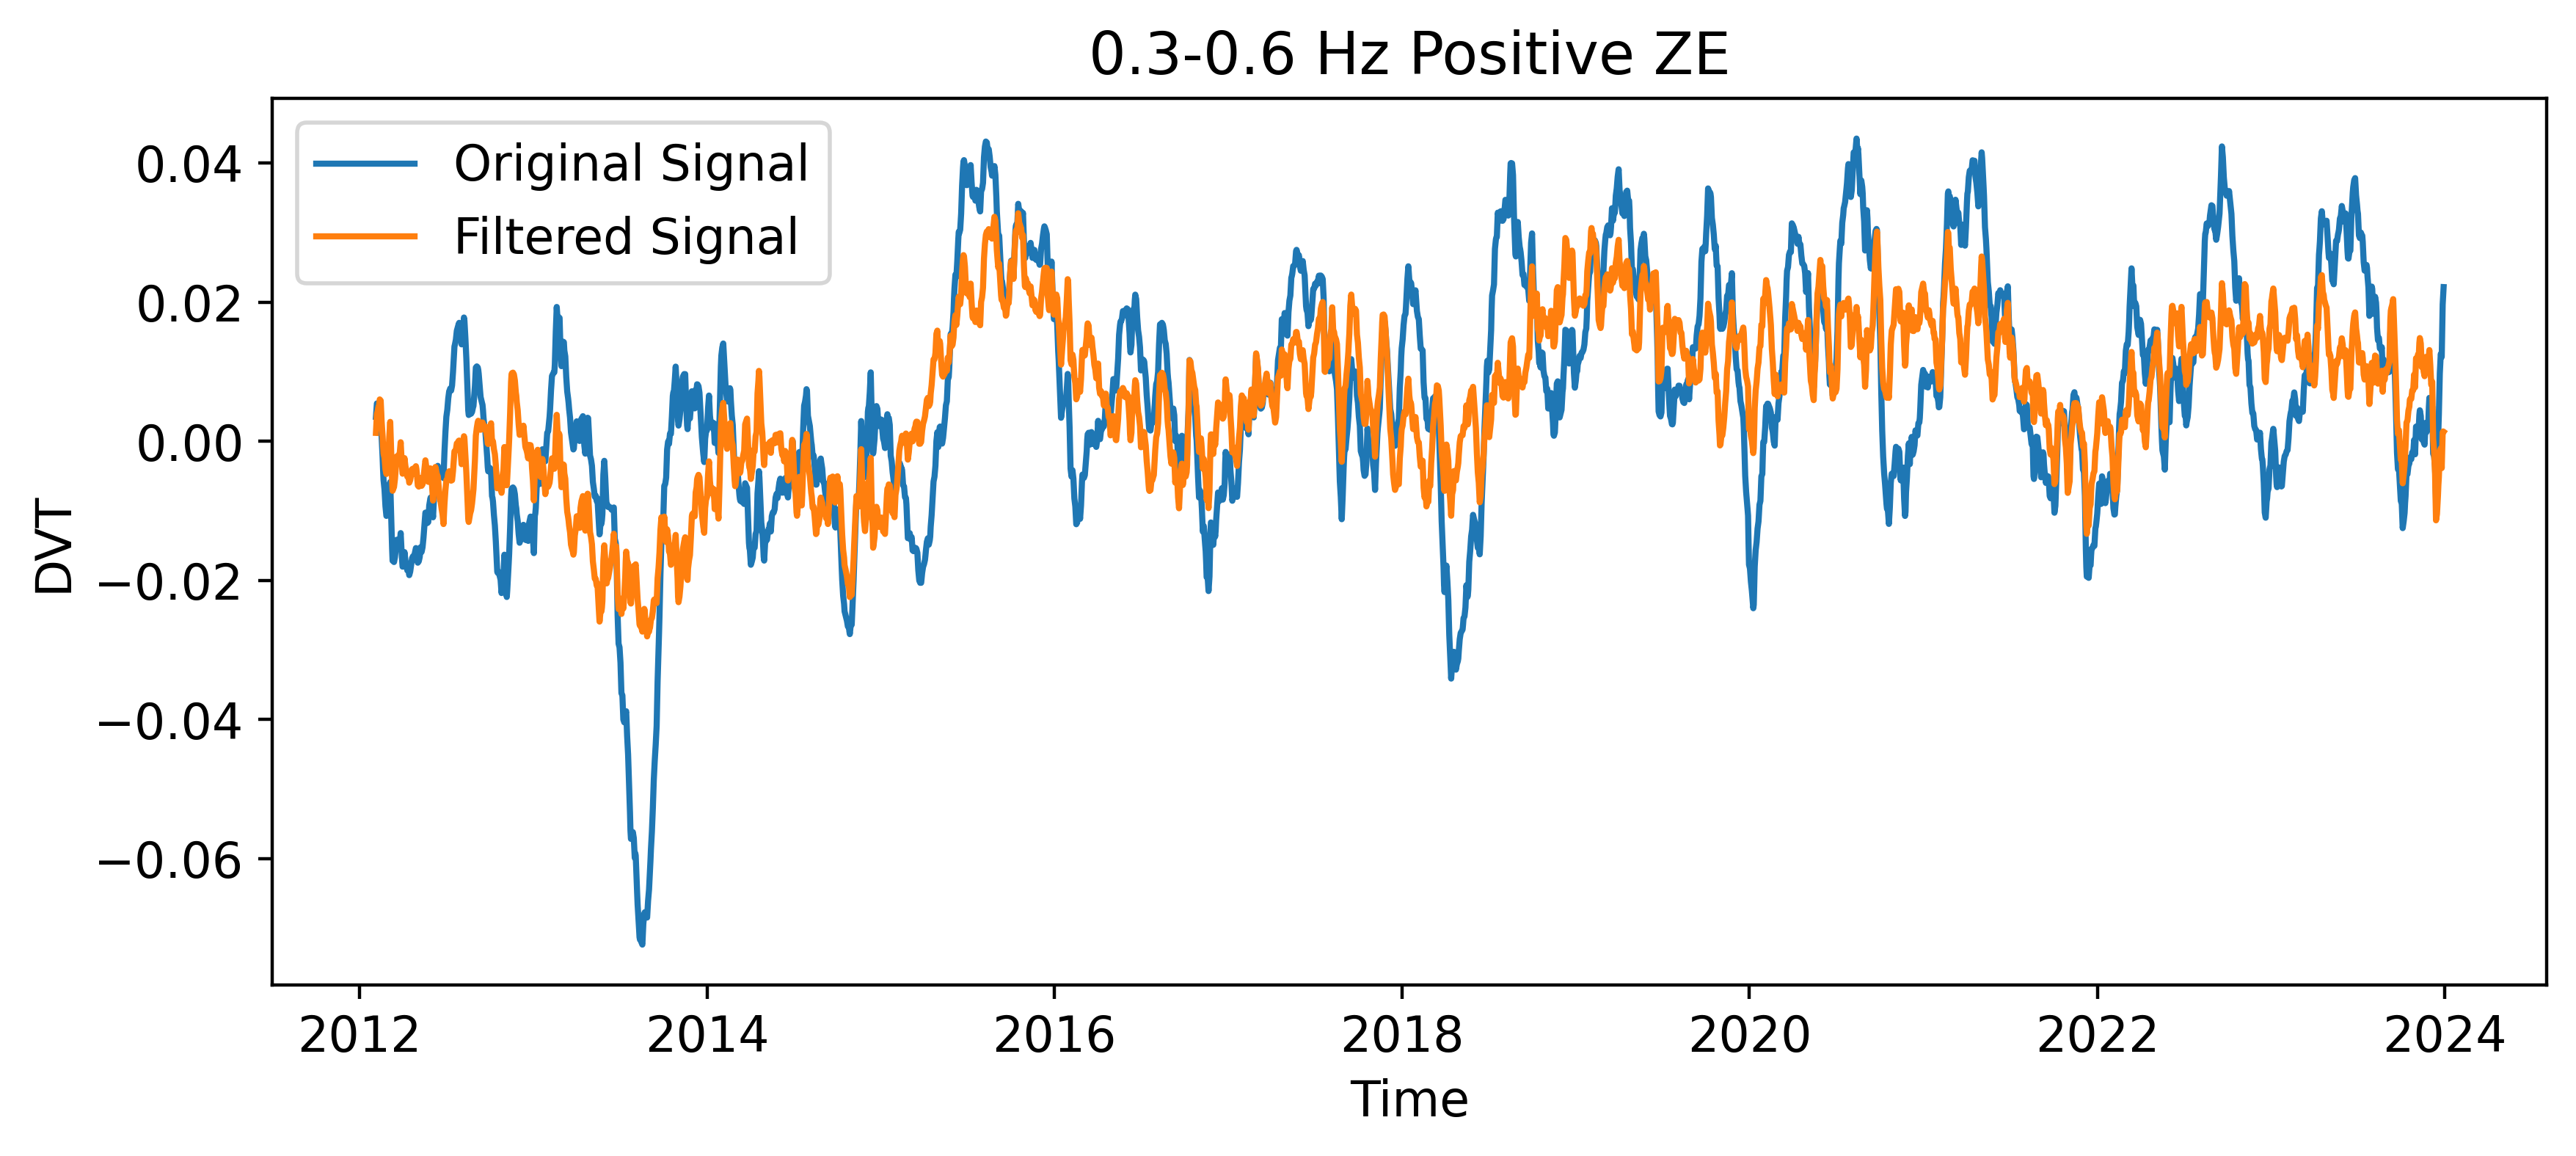

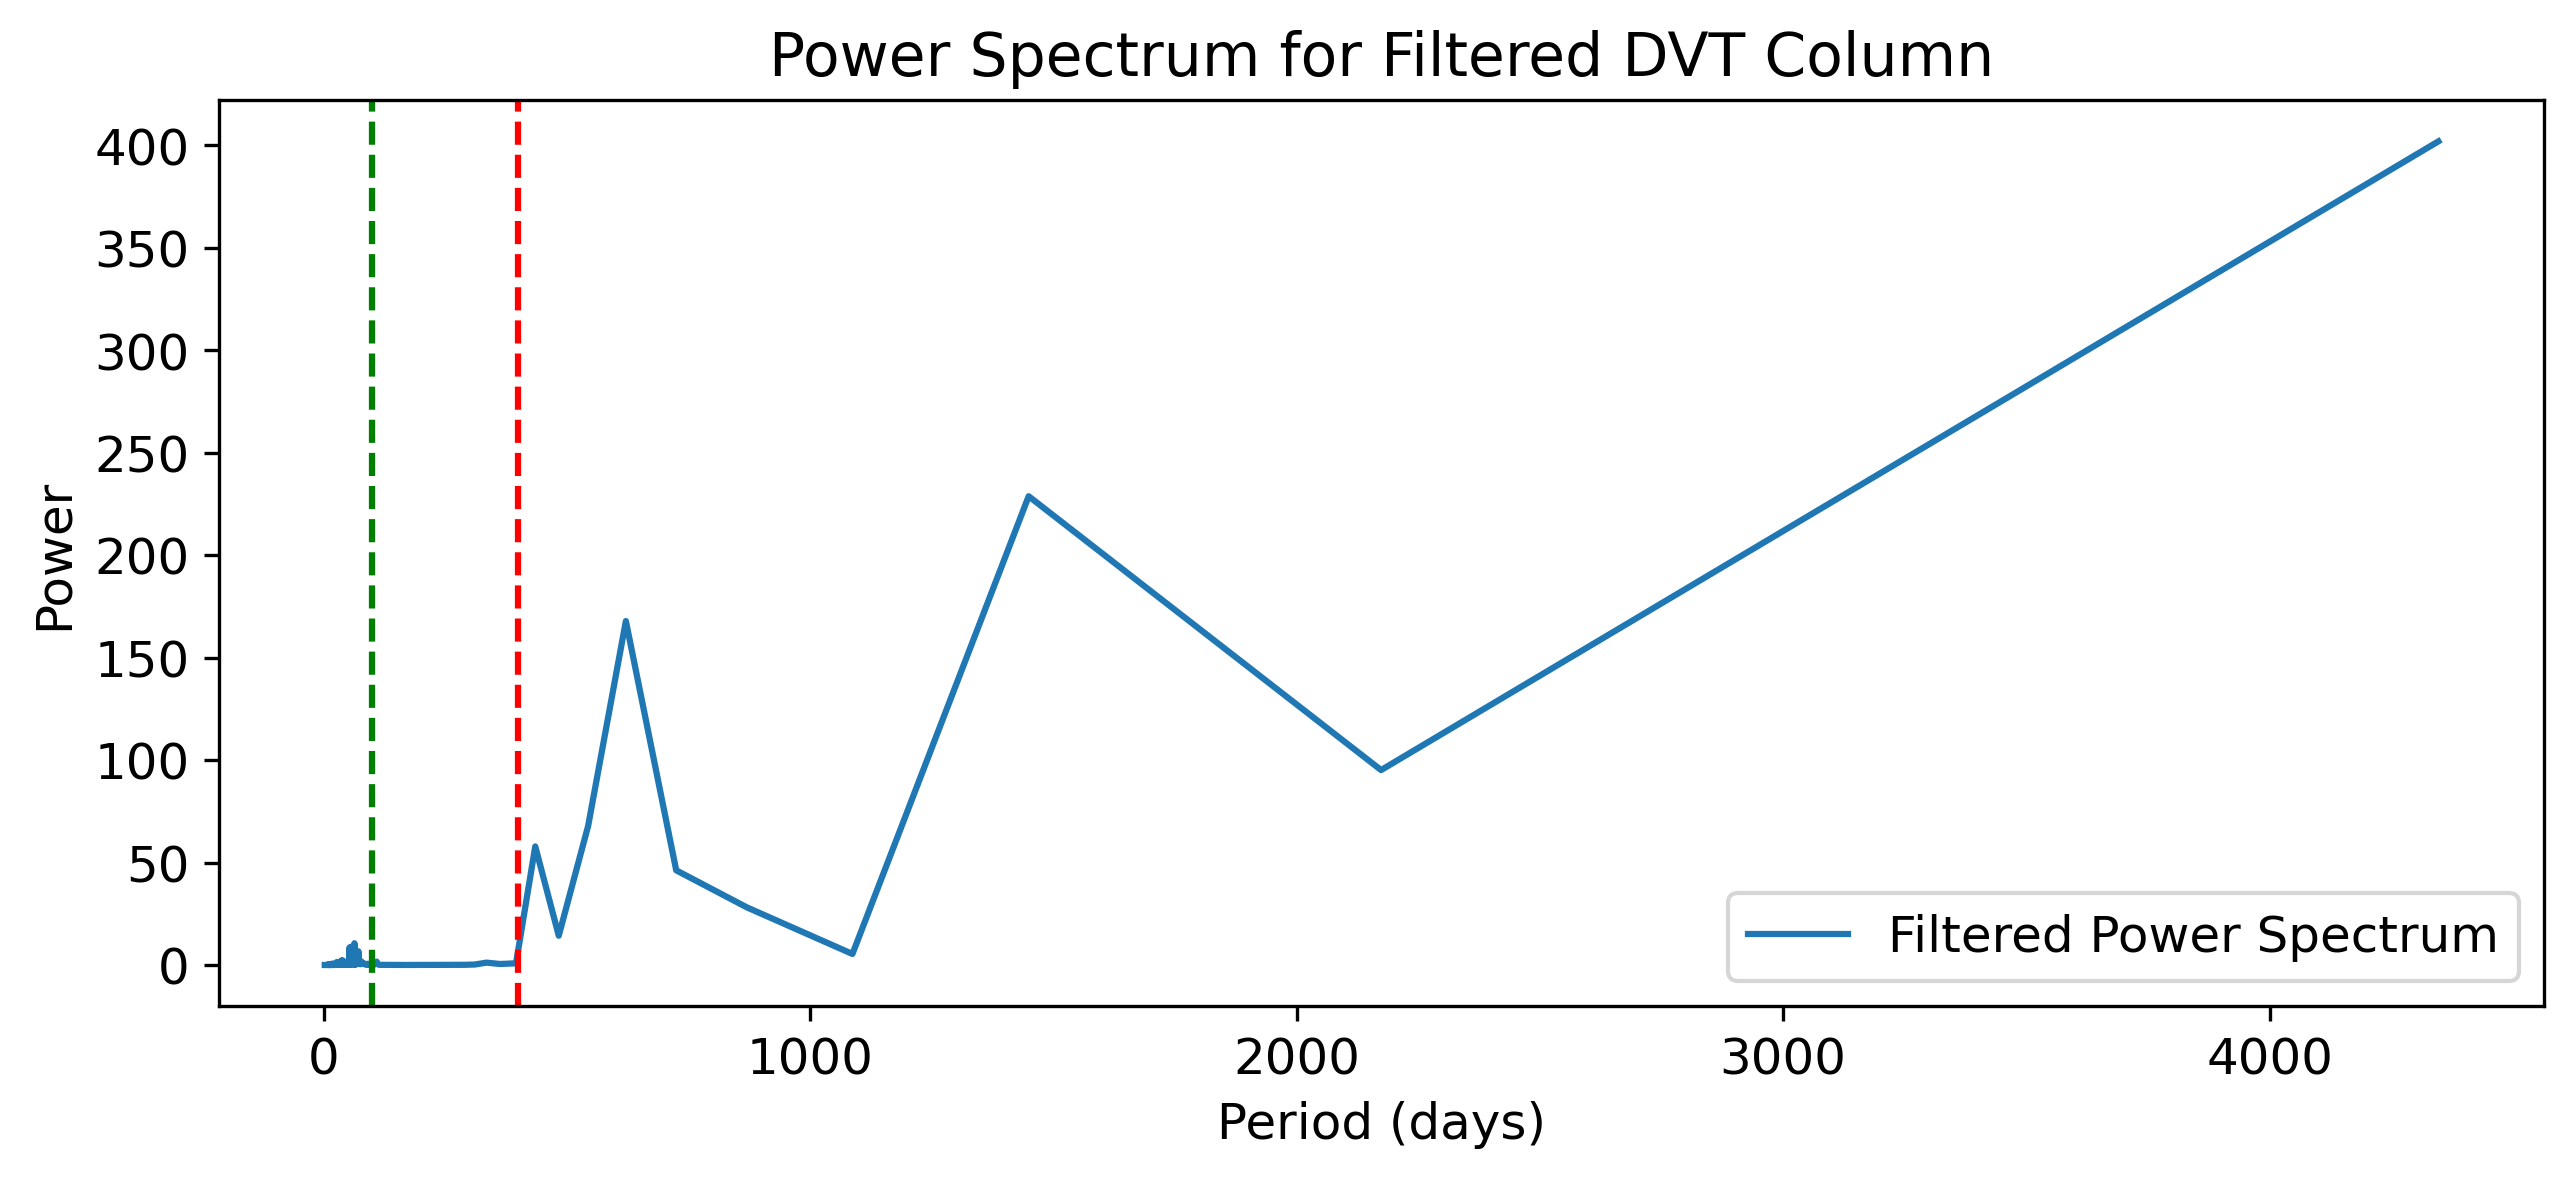

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

# Assuming weighted_dvv_df is already defined
# weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])

# Extract the 'Weighted Δv/v' column into a separate variable
dvt_values = weighted_dvv_df['Weighted Δv/v'].values

# Interpolate or fill NaNs in the signal
dvt_values_filled = pd.Series(dvt_values).interpolate().fillna(method='bfill').fillna(method='ffill').values

# Define the sample rate
samplingrate = 1  # Sample rate is 1 sample per day
fs = 1 / samplingrate

# Define the stop band
lowcut = 1 / 400  # 1/500 days
highcut = 1 / 100  # 1/180 days

# Design the band-stop filter
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='bandstop')

# Apply the band-stop filter to the signal
filtered_dvt_values = filtfilt(b, a, dvt_values_filled)

# Perform FFT on the original signal
n = len(dvt_values_filled)
dvt_fft = fft(dvt_values_filled)
frequencies = fftfreq(n, d=1/fs)
power_spectrum = np.abs(dvt_fft)**2

# Perform FFT on the filtered signal
filtered_dvt_fft = fft(filtered_dvt_values)
filtered_power_spectrum = np.abs(filtered_dvt_fft)**2

# Get the positive frequencies and power spectrum
positive_frequencies = frequencies[frequencies > 0]
positive_power_spectrum = power_spectrum[frequencies > 0]
filtered_positive_power_spectrum = filtered_power_spectrum[frequencies > 0]
plt.rcParams.update({'font.size': 12})
# Plot the power spectrum of the original signal
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(1/positive_frequencies, positive_power_spectrum, label='Original Power Spectrum')
plt.axvline(x=1/lowcut, color='r', linestyle='--')
plt.axvline(x=1/highcut, color='g', linestyle='--')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Power Spectrum for Original DVT Column')
plt.legend()
plt.show()

# Plot the original and filtered signals
plt.figure(figsize=(10, 4), dpi=400)
plt.plot(weighted_dvv_df.index, dvt_values, label='Original Signal')
plt.plot(weighted_dvv_df.index, filtered_dvt_values, label='Filtered Signal')
plt.xlabel('Time')
plt.ylabel('DVT')
plt.title('0.3-0.6 Hz Positive ZE')
plt.legend()
plt.show()

# Plot the power spectrum of the filtered signal
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(1/positive_frequencies, filtered_positive_power_spectrum, label='Filtered Power Spectrum')
plt.axvline(x=1/lowcut, color='r', linestyle='--')
plt.axvline(x=1/highcut, color='g', linestyle='--')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Power Spectrum for Filtered DVT Column')
plt.legend()
plt.show()


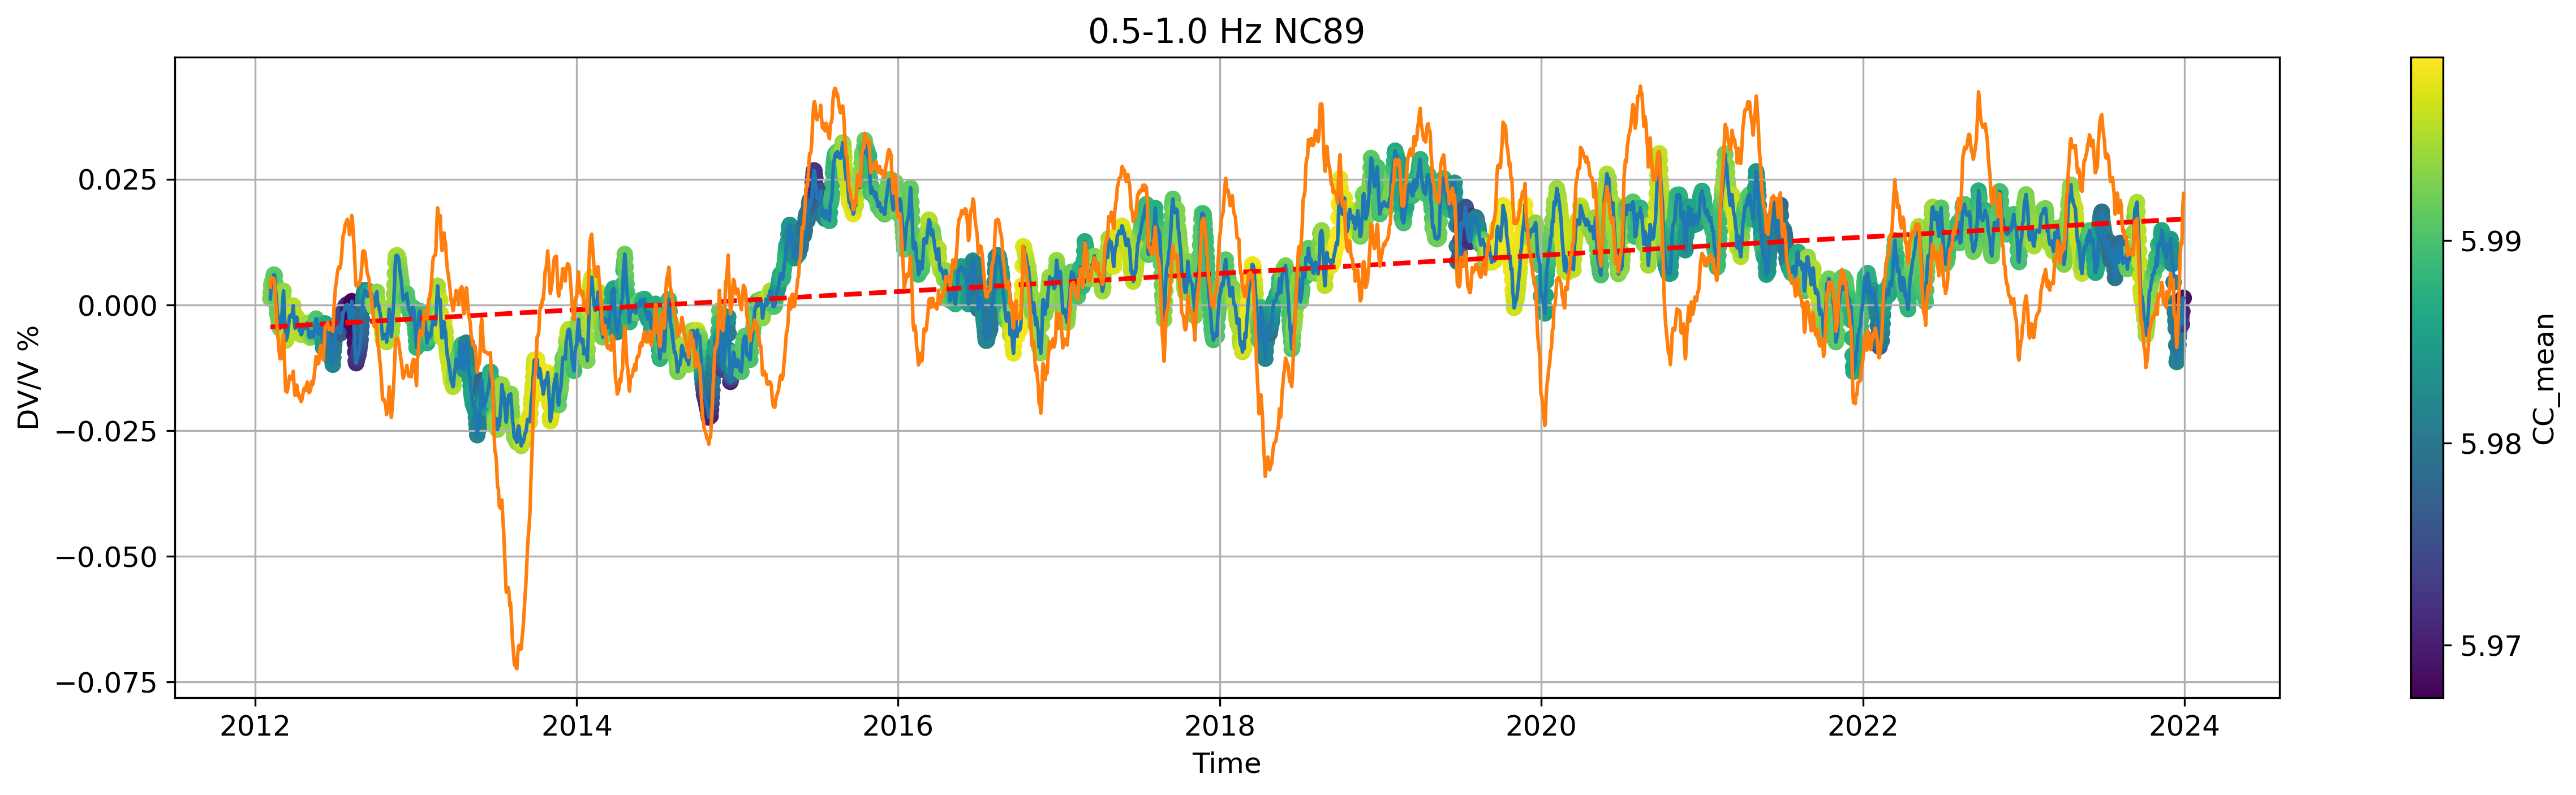

In [48]:
import numpy as np

# Convert the datetime index to a numerical value (e.g., using the ordinal value)
numerical_index = weighted_dvv_df.index.map(lambda x: x.toordinal())

# Fit a linear model to the filtered_dvt_values vs. numerical index
slope, intercept = np.polyfit(numerical_index, filtered_dvt_values, 1)

# Generate the fitted line values
fitted_line = slope * numerical_index + intercept

# Plot the original data along with the fitted line
plt.figure(figsize=(20, 5), dpi=300)
sc = plt.scatter(weighted_dvv_df.index, filtered_dvt_values, c=CC_mean, cmap=cmap, norm=norm)
plt.plot(weighted_dvv_df.index, filtered_dvt_values, label='Filtered Signal')
plt.plot(weighted_dvv_df.index, fitted_line, 'r--', linewidth=2, label='Fitted Line')  # Add red fitted line
plt.plot(weighted_dvv_df.index, dvt_values, label='Original Signal')
plt.colorbar(sc, label='CC_mean')
plt.xlabel('Time')
plt.ylabel('DV/V %')
plt.title('0.5-1.0 Hz NC89')
plt.grid(True)
plt.rcParams.update({'font.size': 20})
plt.show()


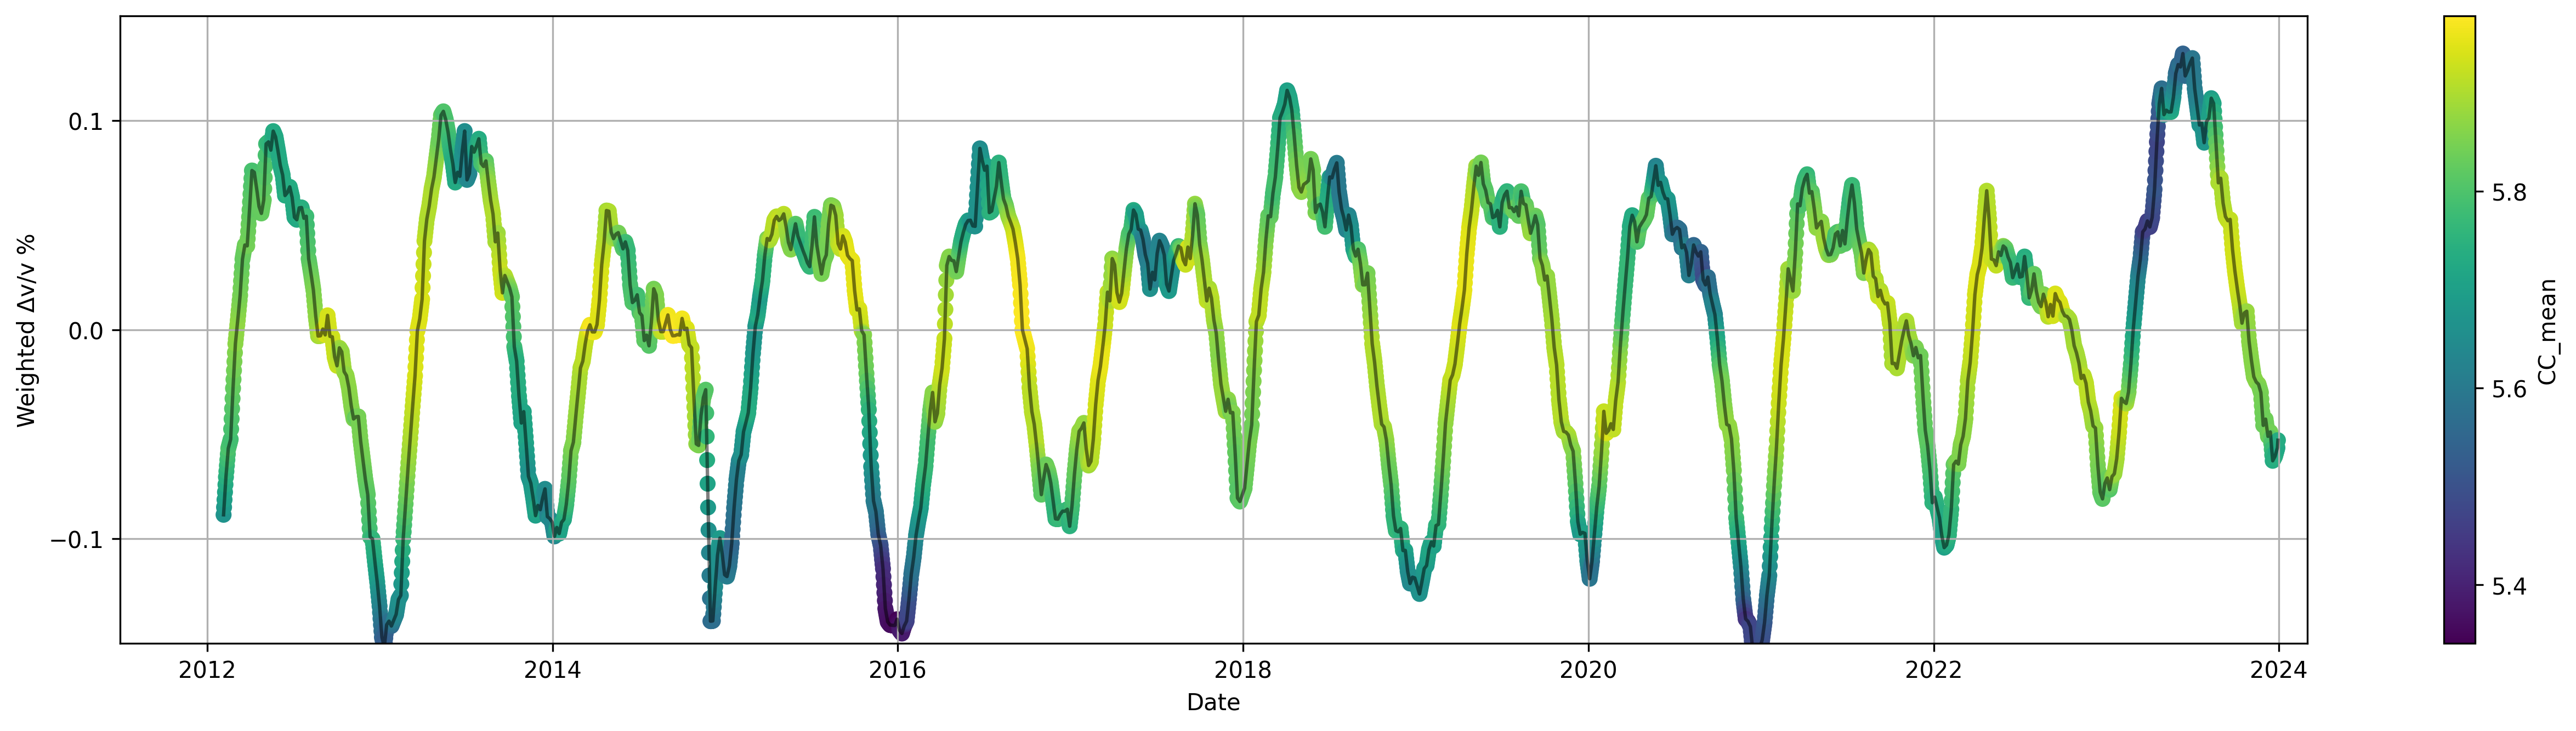

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd

# Define the paths to your CSV files
file_paths = [
    'NC89 Results/89_60daystack_0p1to0p3 positiveZN 1060svd7.csv',
    'NC89 Results/89_60daystack_0p1to0p3 negativeZN 6010svd7.csv',
    'NC89 Results/89_60daystack_0p1to0p3 positiveNE 1060svd7.csv',
    'NC89 Results/89_60daystack_0p1to0p3 negativeNE 6010svd7.csv',
    'NC89 Results/89_60daystack_0p1to0p3 positiveZE 1060svd7.csv',
    'NC89 Results/89_60daystack_0p1to0p3 negativeZE 6010svd7.csv',
]


dataframes = []
for path in file_paths:
    df = pd.read_csv(path)
    dataframes.append(df)

# Parse timestamps and set them as the index
for df in dataframes:
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)

# Create a unified daily time index spanning the full range of all dataframes
start_date = min(df.index.min() for df in dataframes)
end_date = max(df.index.max() for df in dataframes)
daily_index = pd.date_range(start=start_date, end=end_date, freq='D')

# Interpolate data for each dataframe to match the daily index
interpolated_dfs = [df.reindex(daily_index).interpolate() for df in dataframes]

# Define the date range to exclude
exclude_ranges = [
    (pd.to_datetime("2023-12-01"), pd.to_datetime("2024-01-30")),
    (pd.to_datetime("2009-11-10"), pd.to_datetime("2012-01-05"))
]

# Exclude the specified date ranges
for start_date, end_date in exclude_ranges:
    for i in range(len(interpolated_dfs)):
        interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)

# Calculate CC_mean using squared correlation coefficients for each time point
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)

# Calculate weighted Δu/u using squared CCT and DVT
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Normalize CC_mean for coloring
norm = mcolors.Normalize(vmin=CC_mean.min(), vmax=CC_mean.max())
cmap = cm.viridis  # Can choose any available colormap

# Create a DataFrame for the weighted Δv/v time series
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])

# Add a 30-day offset to the index
weighted_dvv_df.index = weighted_dvv_df.index + pd.DateOffset(days=30)

# Plotting the weighted Δv/v time series with color-coded CC_mean
plt.figure(figsize=(18, 5), dpi=300)
# Scatter plot for individual markers with color coding
sc = plt.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cmap, norm=norm, label='Weighted Δv/v')
# Line plot to connect markers
plt.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)  # Adjust alpha for line transparency
plt.colorbar(sc, label='CC_mean')

#plt.title('Weighted Δv/v For HYS14 1.0-3.0Hz Combined')
plt.xlabel('Date')
plt.ylim([-0.15, 0.15])
plt.ylabel('Weighted Δv/v %')
plt.grid(True)

# Set x-axis limits
plot_start_date = pd.to_datetime("2011-07-01")
plot_end_date = pd.to_datetime("2024-03-01")
plt.rcParams.update({'font.size': 25})
plt.xlim([plot_start_date, plot_end_date])
plt.xticks()
plt.tight_layout()
plt.show()


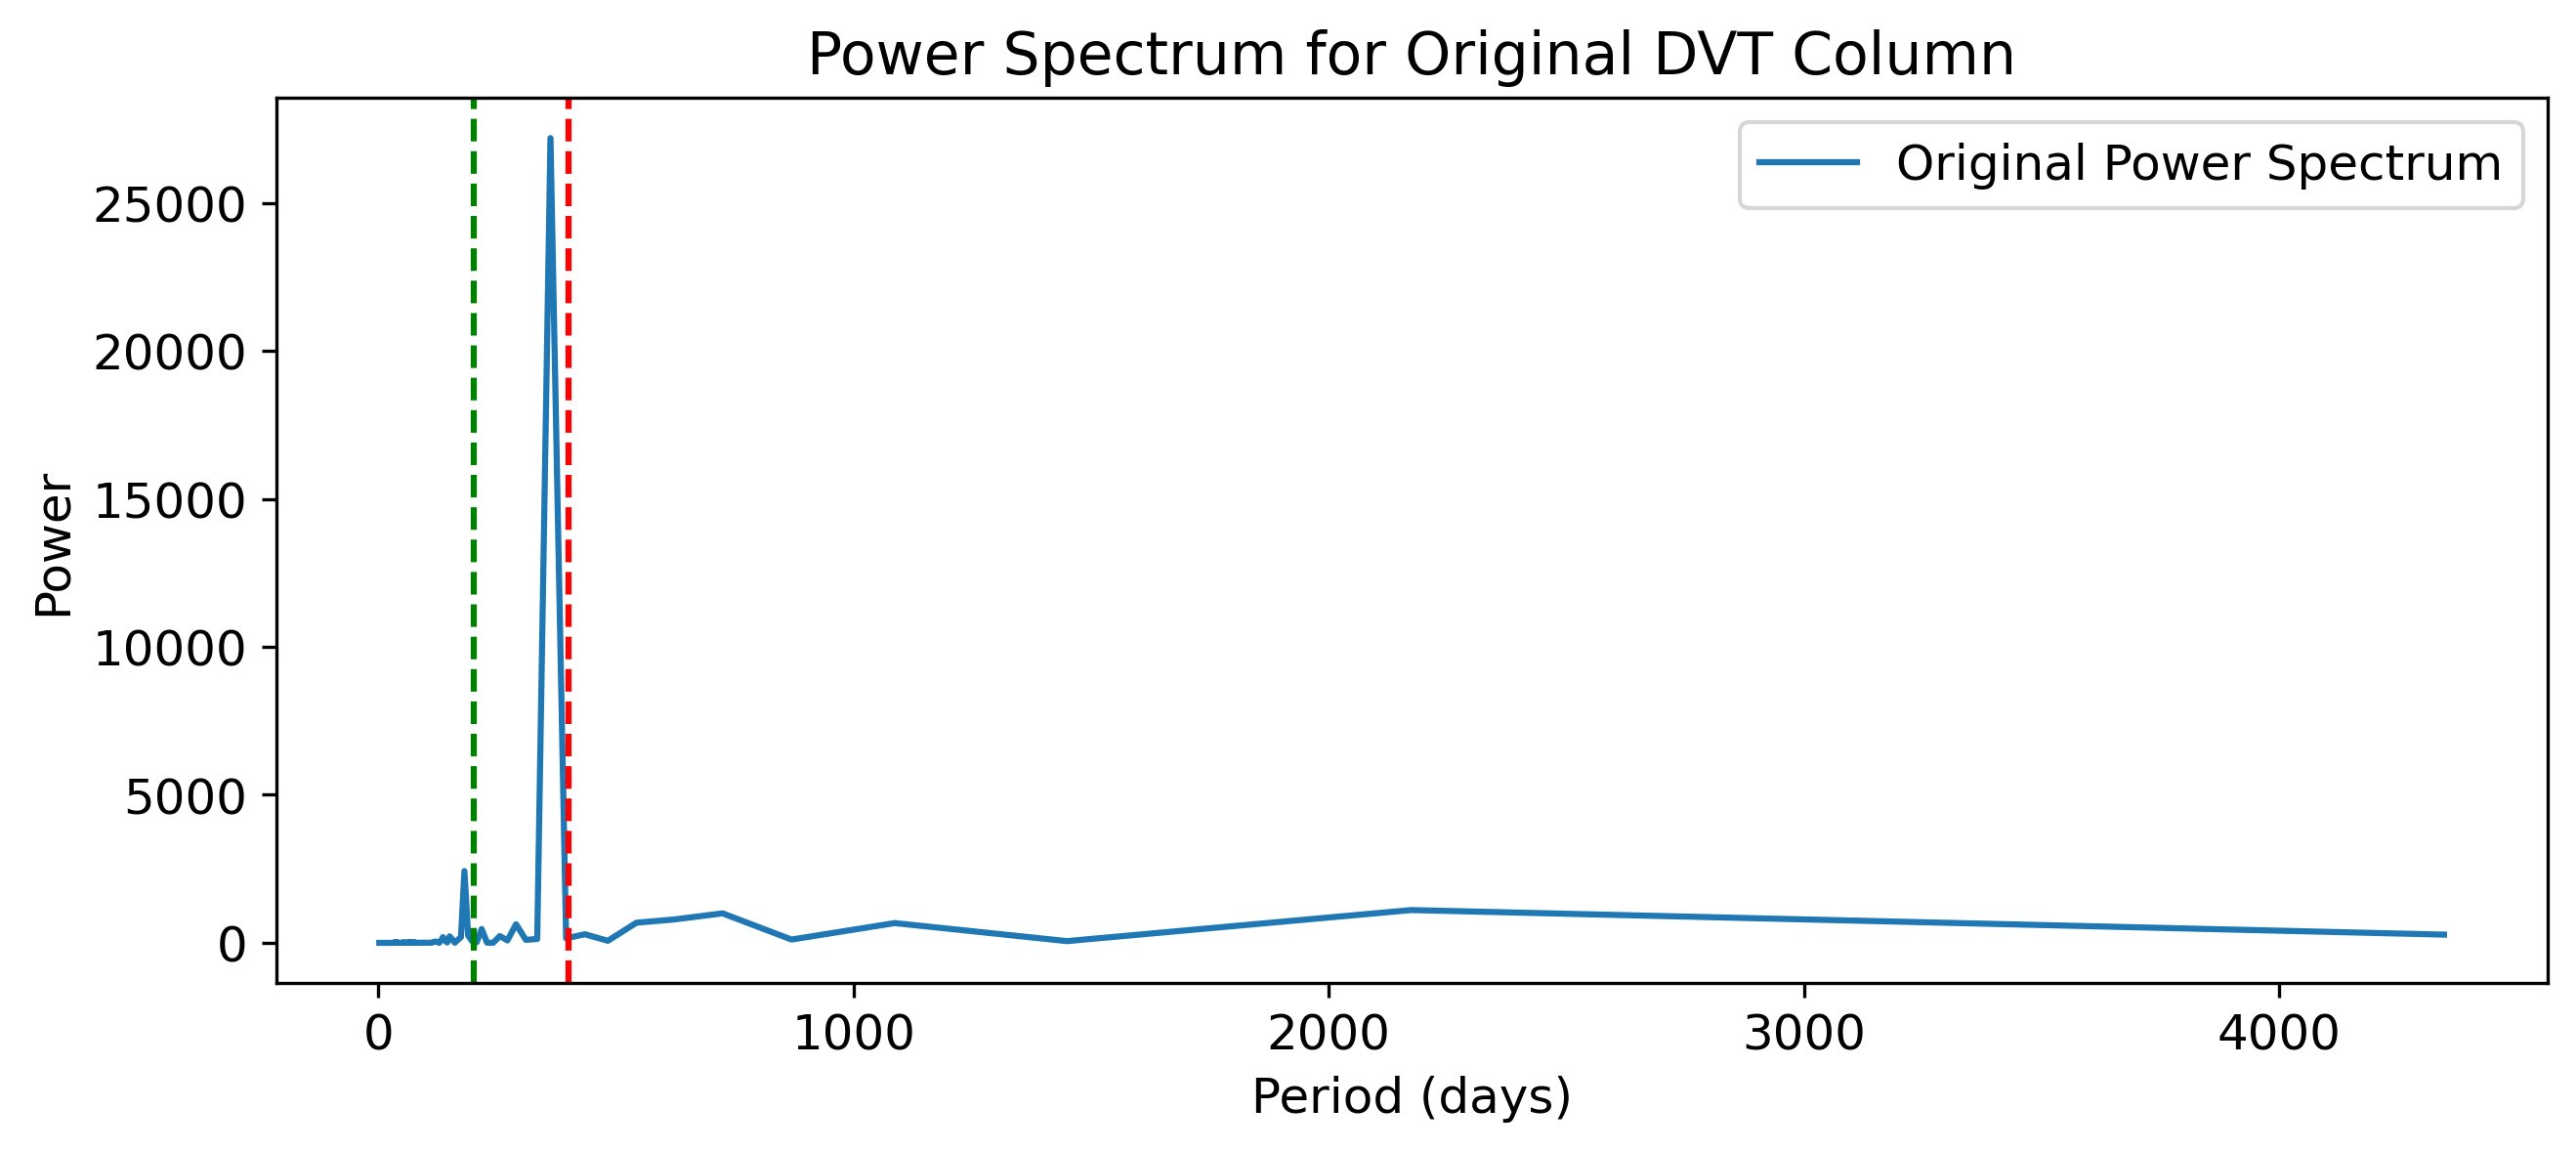

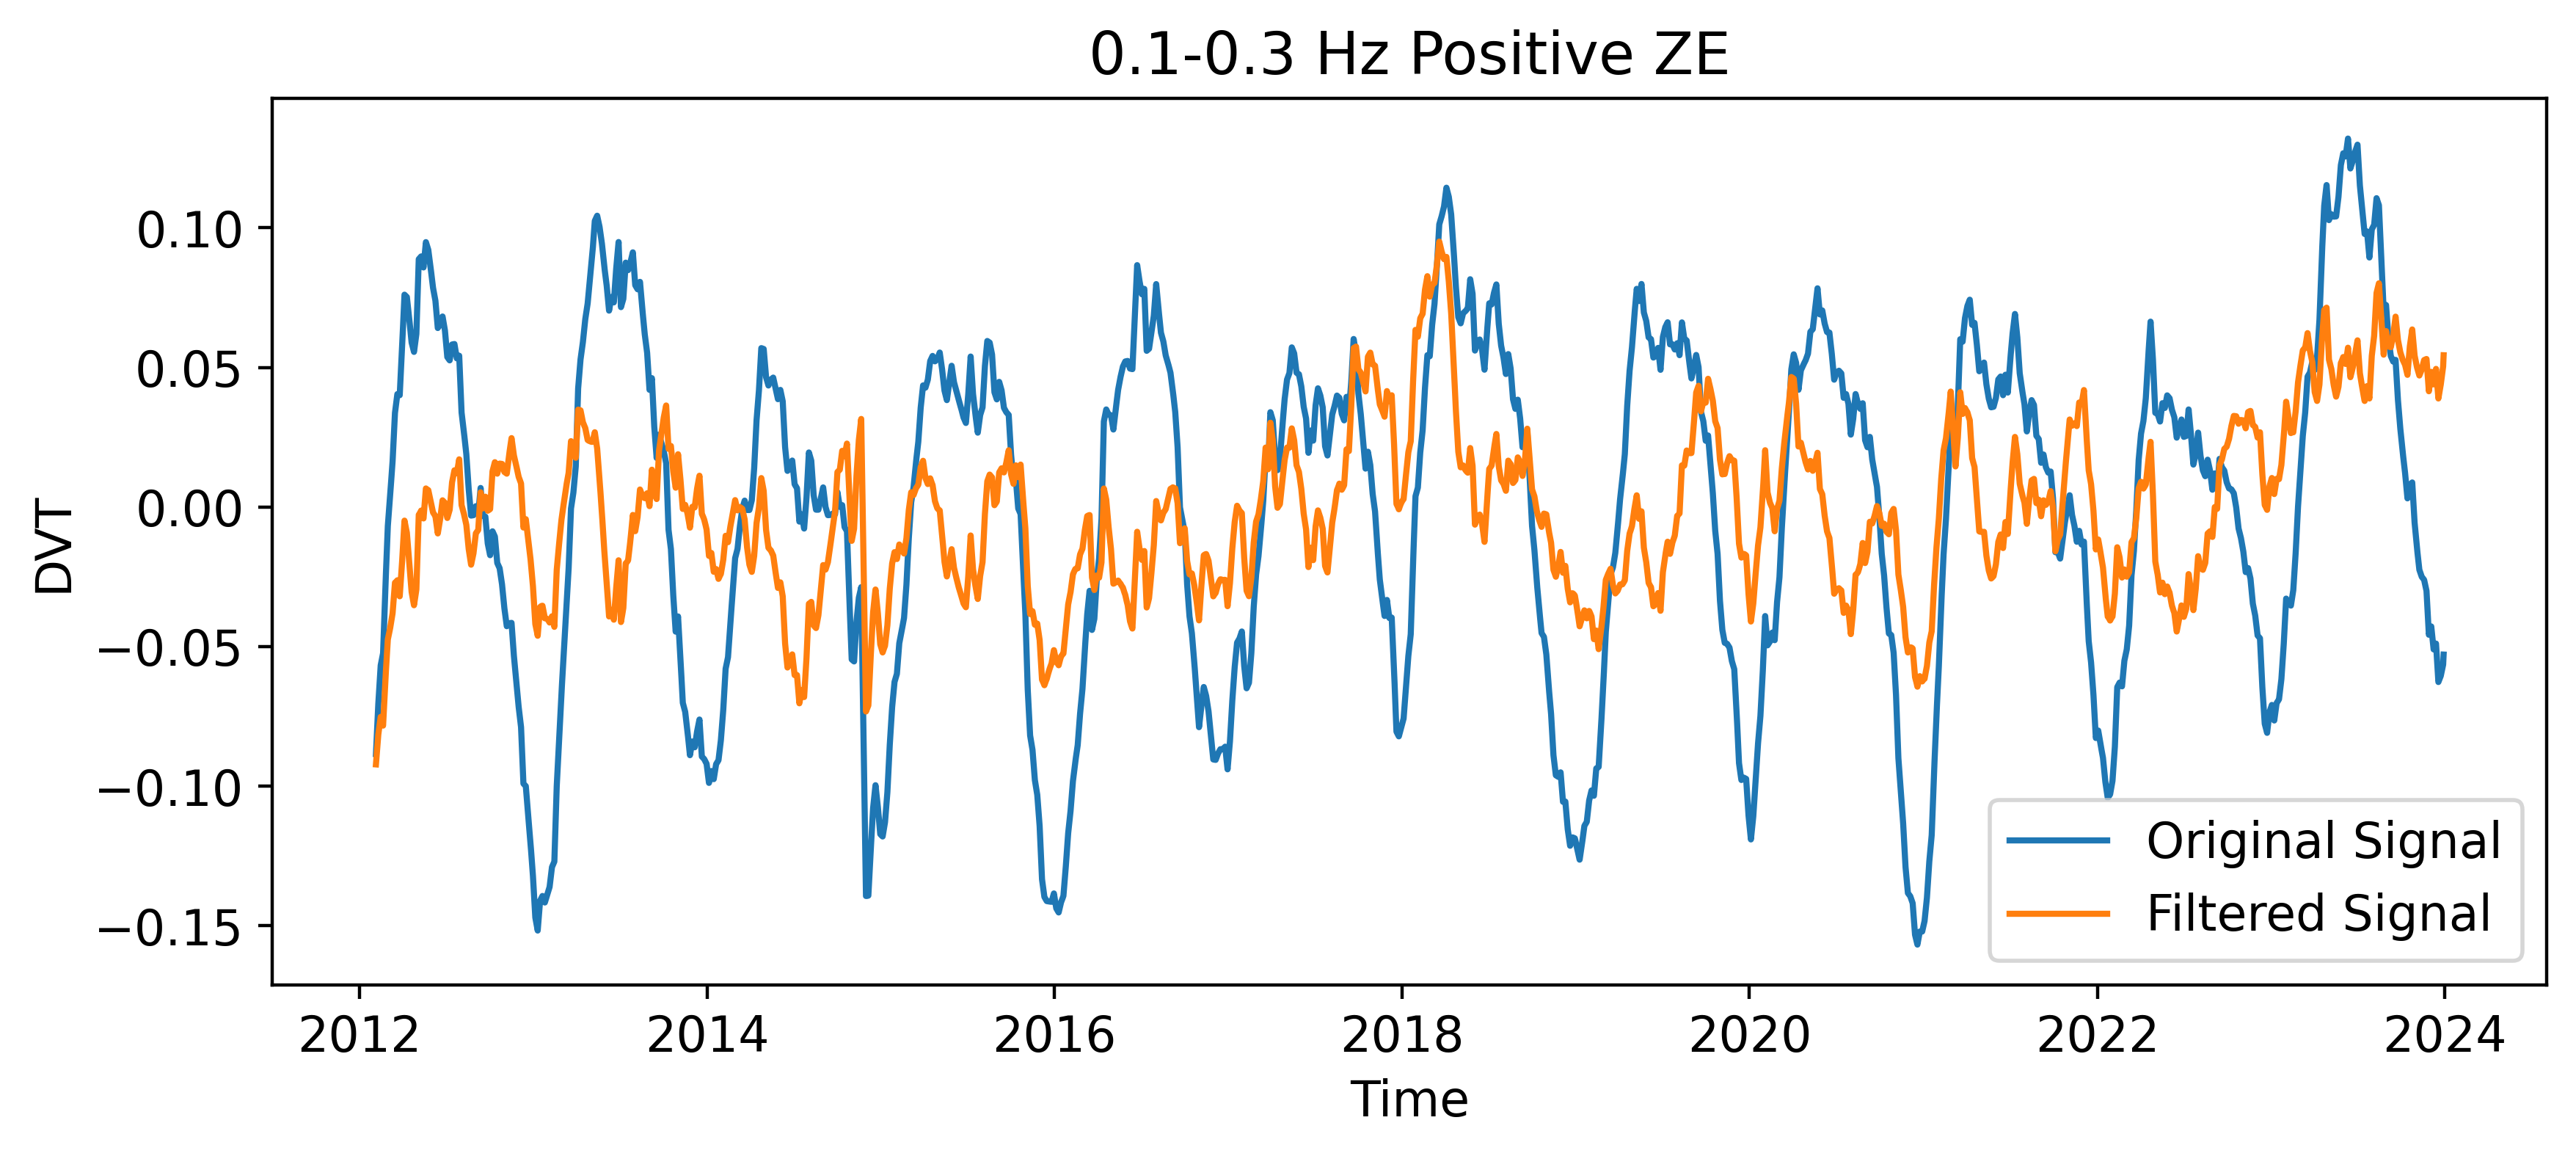

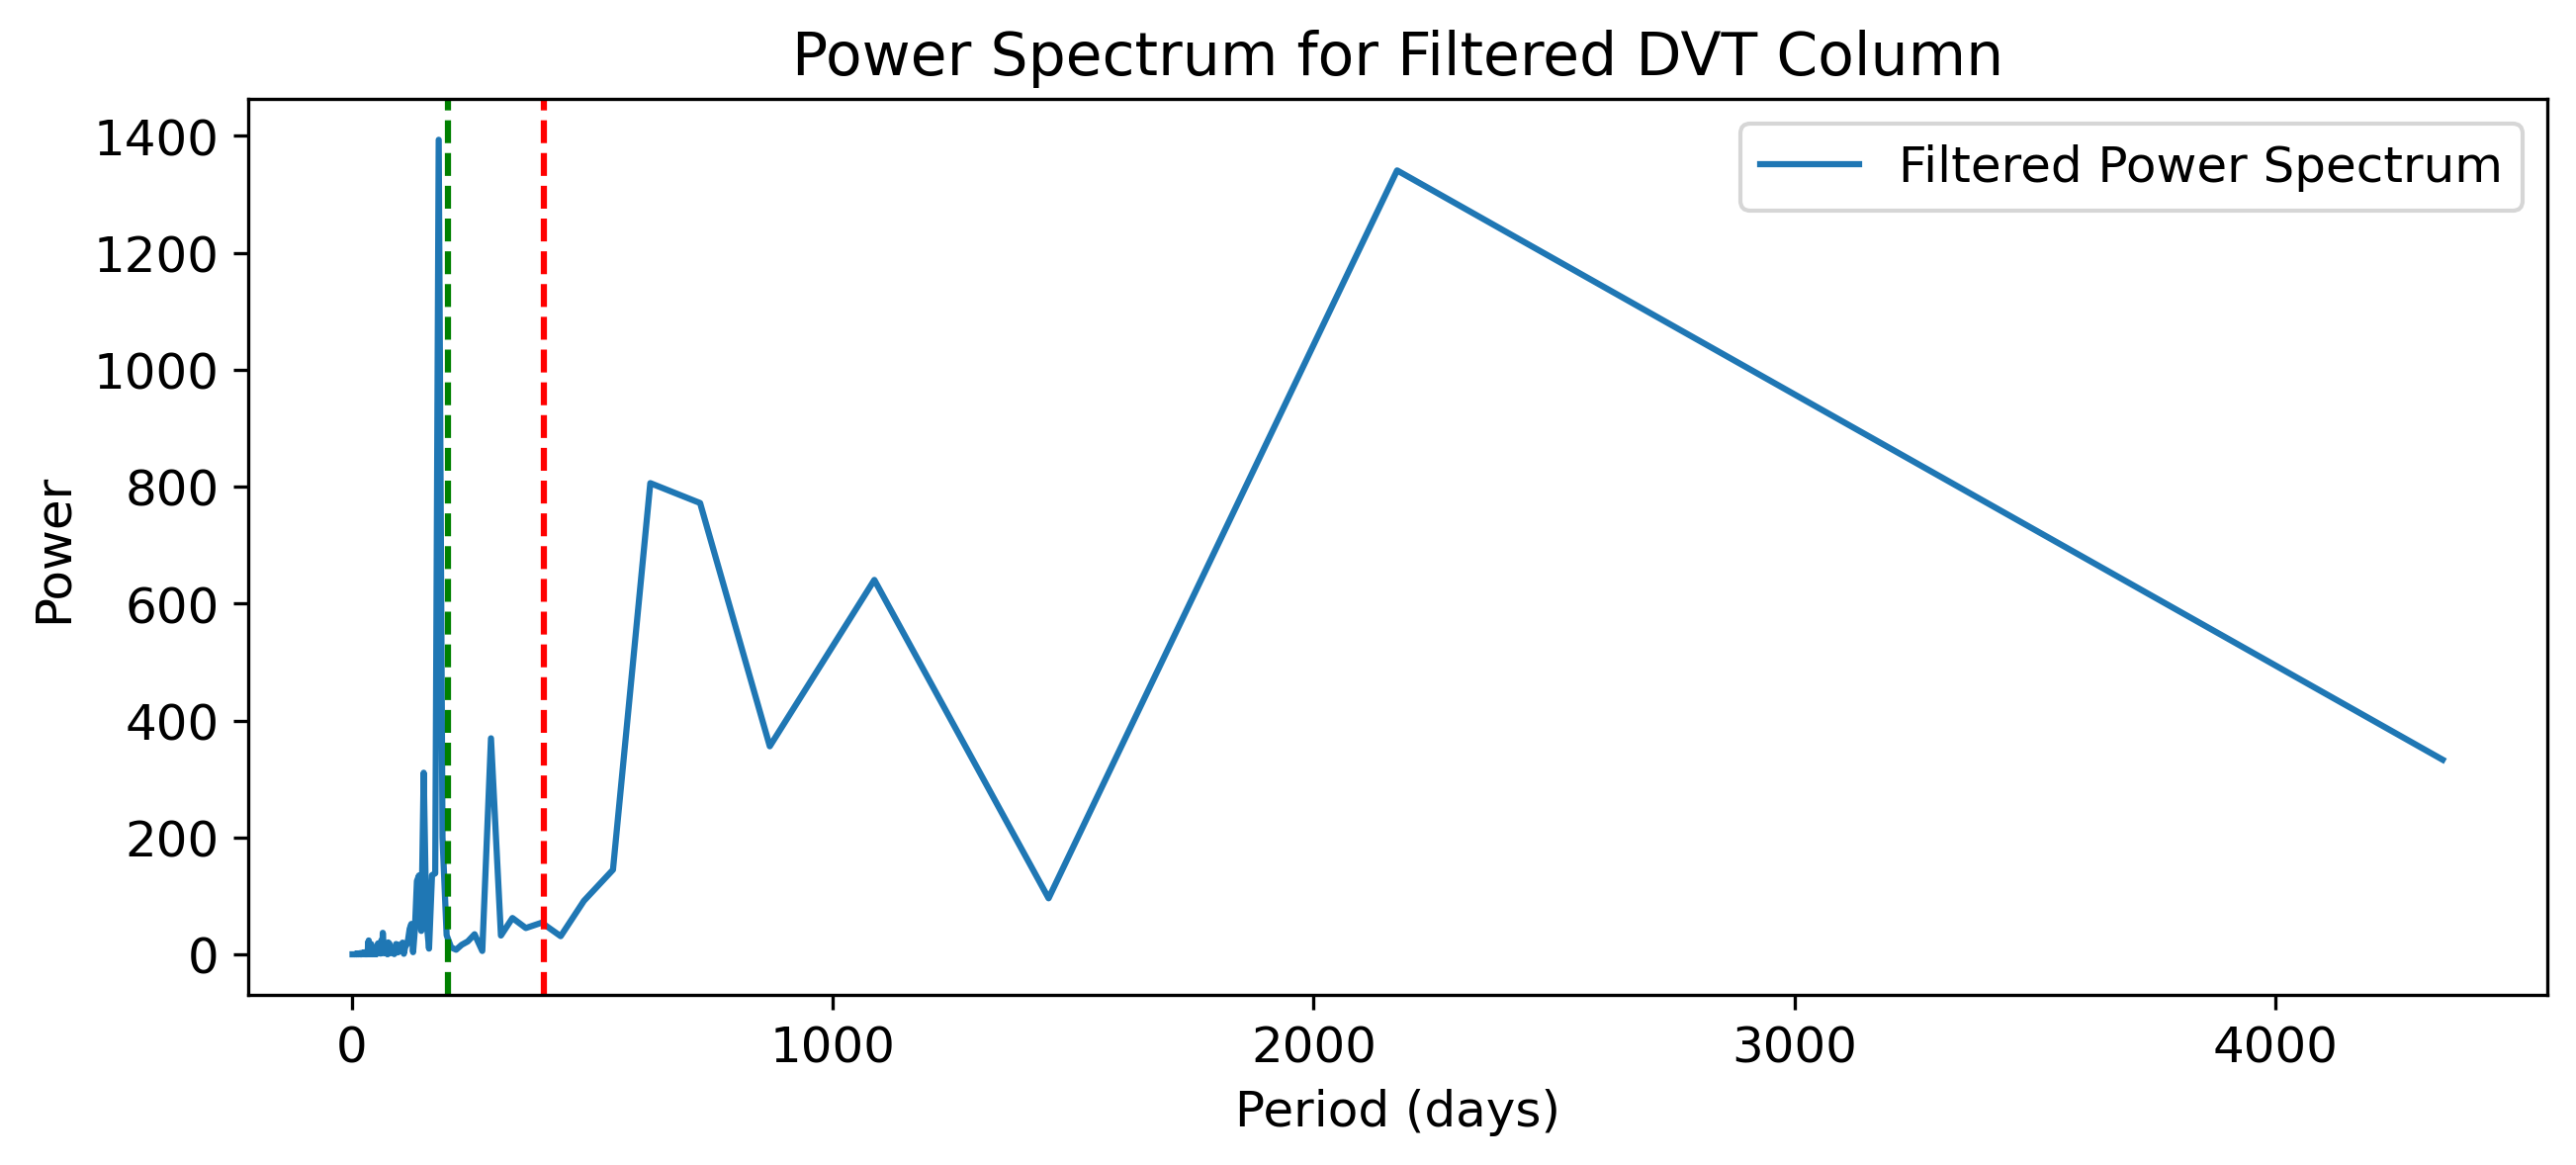

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

# Assuming weighted_dvv_df is already defined
# weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])

# Extract the 'Weighted Δv/v' column into a separate variable
dvt_values = weighted_dvv_df['Weighted Δv/v'].values

# Interpolate or fill NaNs in the signal
dvt_values_filled = pd.Series(dvt_values).interpolate().fillna(method='bfill').fillna(method='ffill').values

# Define the sample rate
samplingrate = 1  # Sample rate is 1 sample per day
fs = 1 / samplingrate

# Define the stop band
lowcut = 1 / 400  # 1/500 days
highcut = 1 / 200  # 1/180 days

# Design the band-stop filter
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='bandstop')

# Apply the band-stop filter to the signal
filtered_dvt_values = filtfilt(b, a, dvt_values_filled)

# Perform FFT on the original signal
n = len(dvt_values_filled)
dvt_fft = fft(dvt_values_filled)
frequencies = fftfreq(n, d=1/fs)
power_spectrum = np.abs(dvt_fft)**2

# Perform FFT on the filtered signal
filtered_dvt_fft = fft(filtered_dvt_values)
filtered_power_spectrum = np.abs(filtered_dvt_fft)**2

# Get the positive frequencies and power spectrum
positive_frequencies = frequencies[frequencies > 0]
positive_power_spectrum = power_spectrum[frequencies > 0]
filtered_positive_power_spectrum = filtered_power_spectrum[frequencies > 0]
plt.rcParams.update({'font.size': 12})
# Plot the power spectrum of the original signal
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(1/positive_frequencies, positive_power_spectrum, label='Original Power Spectrum')
plt.axvline(x=1/lowcut, color='r', linestyle='--')
plt.axvline(x=1/highcut, color='g', linestyle='--')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Power Spectrum for Original DVT Column')
plt.legend()
plt.show()

# Plot the original and filtered signals
plt.figure(figsize=(10, 4), dpi=400)
plt.plot(weighted_dvv_df.index, dvt_values, label='Original Signal')
plt.plot(weighted_dvv_df.index, filtered_dvt_values, label='Filtered Signal')
plt.xlabel('Time')
plt.ylabel('DVT')
plt.title('0.1-0.3 Hz Positive ZE')
plt.legend()
plt.show()

# Plot the power spectrum of the filtered signal
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(1/positive_frequencies, filtered_positive_power_spectrum, label='Filtered Power Spectrum')
plt.axvline(x=1/lowcut, color='r', linestyle='--')
plt.axvline(x=1/highcut, color='g', linestyle='--')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Power Spectrum for Filtered DVT Column')
plt.legend()
plt.show()


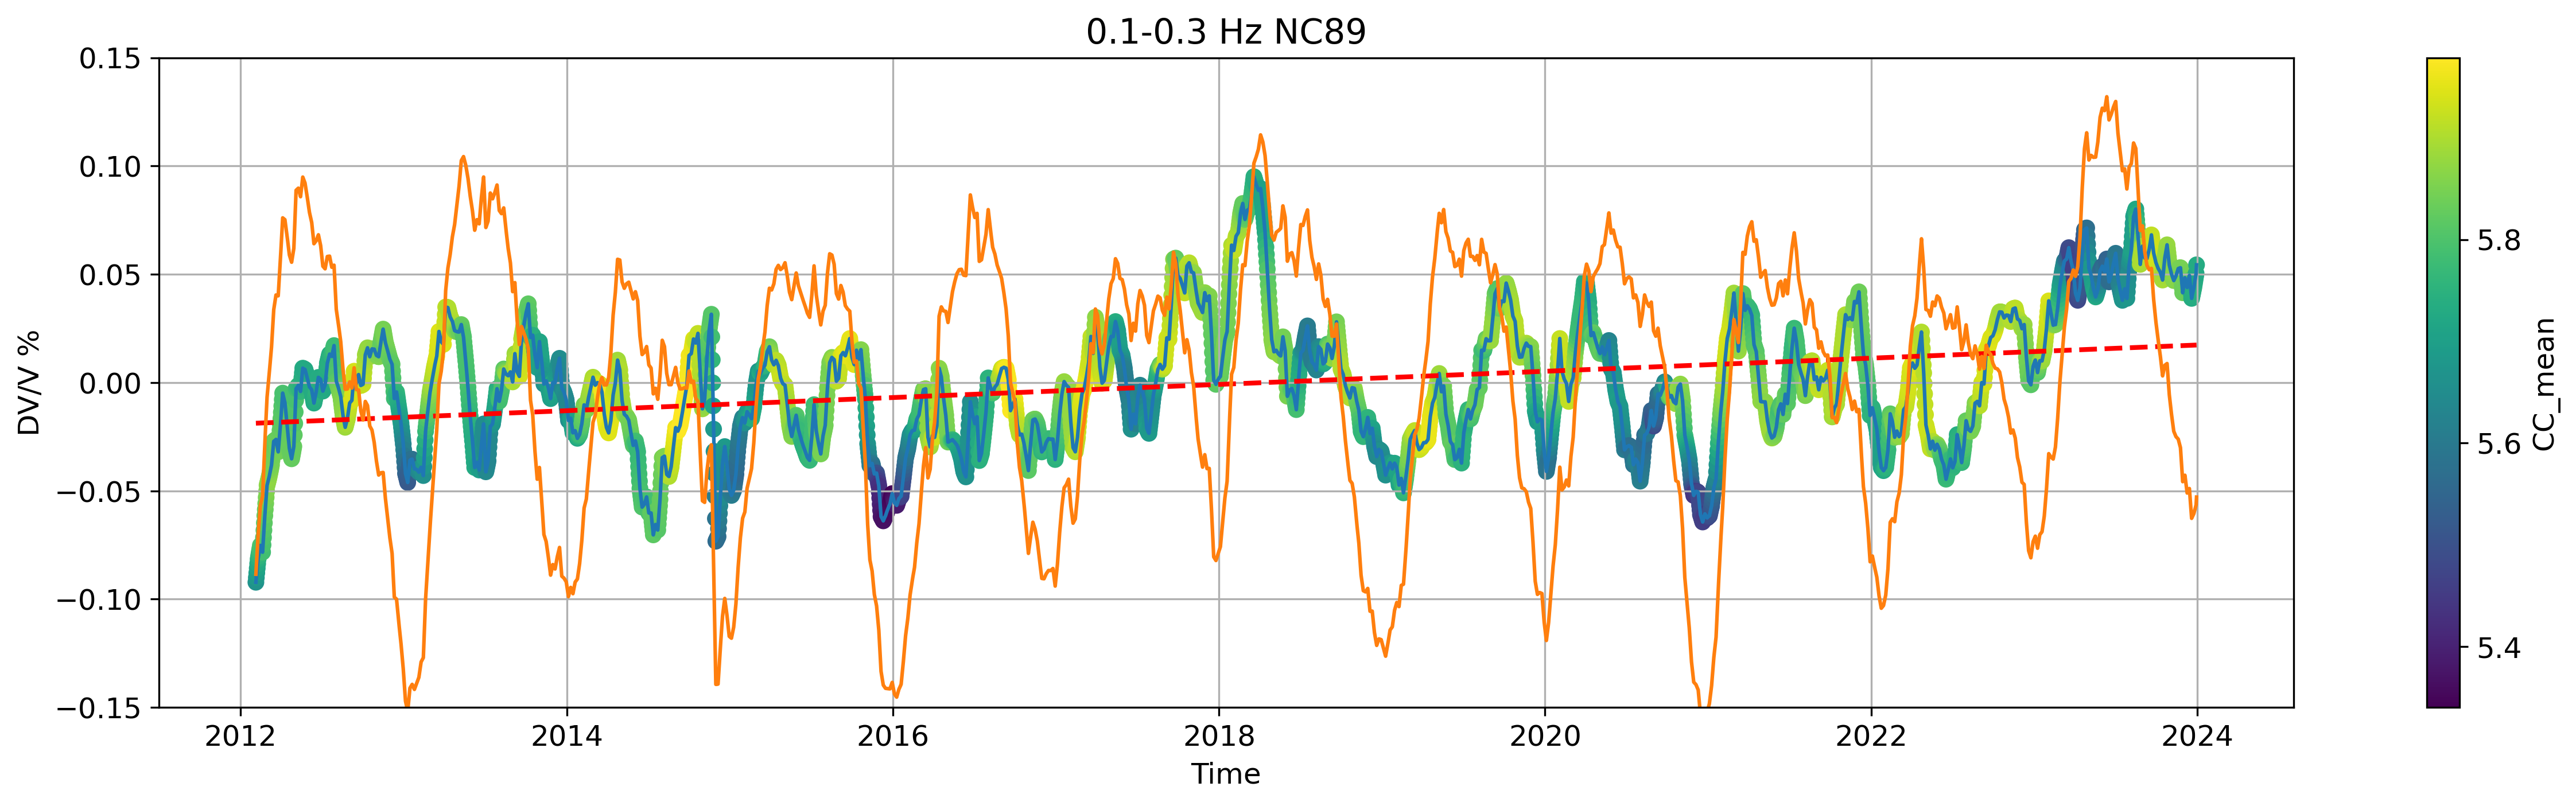

In [41]:
import numpy as np

# Convert the datetime index to a numerical value (e.g., using the ordinal value)
numerical_index = weighted_dvv_df.index.map(lambda x: x.toordinal())

# Fit a linear model to the filtered_dvt_values vs. numerical index
slope, intercept = np.polyfit(numerical_index, filtered_dvt_values, 1)

# Generate the fitted line values
fitted_line = slope * numerical_index + intercept

# Plot the original data along with the fitted line
plt.figure(figsize=(20, 5), dpi=300)
sc = plt.scatter(weighted_dvv_df.index, filtered_dvt_values, c=CC_mean, cmap=cmap, norm=norm)
plt.plot(weighted_dvv_df.index, filtered_dvt_values, label='Filtered Signal')
plt.plot(weighted_dvv_df.index, fitted_line, 'r--', linewidth=2, label='Fitted Line')  # Add red fitted line
plt.plot(weighted_dvv_df.index, dvt_values, label='Original Signal')
plt.colorbar(sc, label='CC_mean')
plt.xlabel('Time')
plt.ylabel('DV/V %')
plt.title('0.1-0.3 Hz NC89')
plt.ylim([-0.15, 0.15])
plt.grid(True)
plt.rcParams.update({'font.size': 20})
plt.show()


Minimum of linear fit: -0.018756823149939983
Maximum of linear fit: 0.017338269924064065


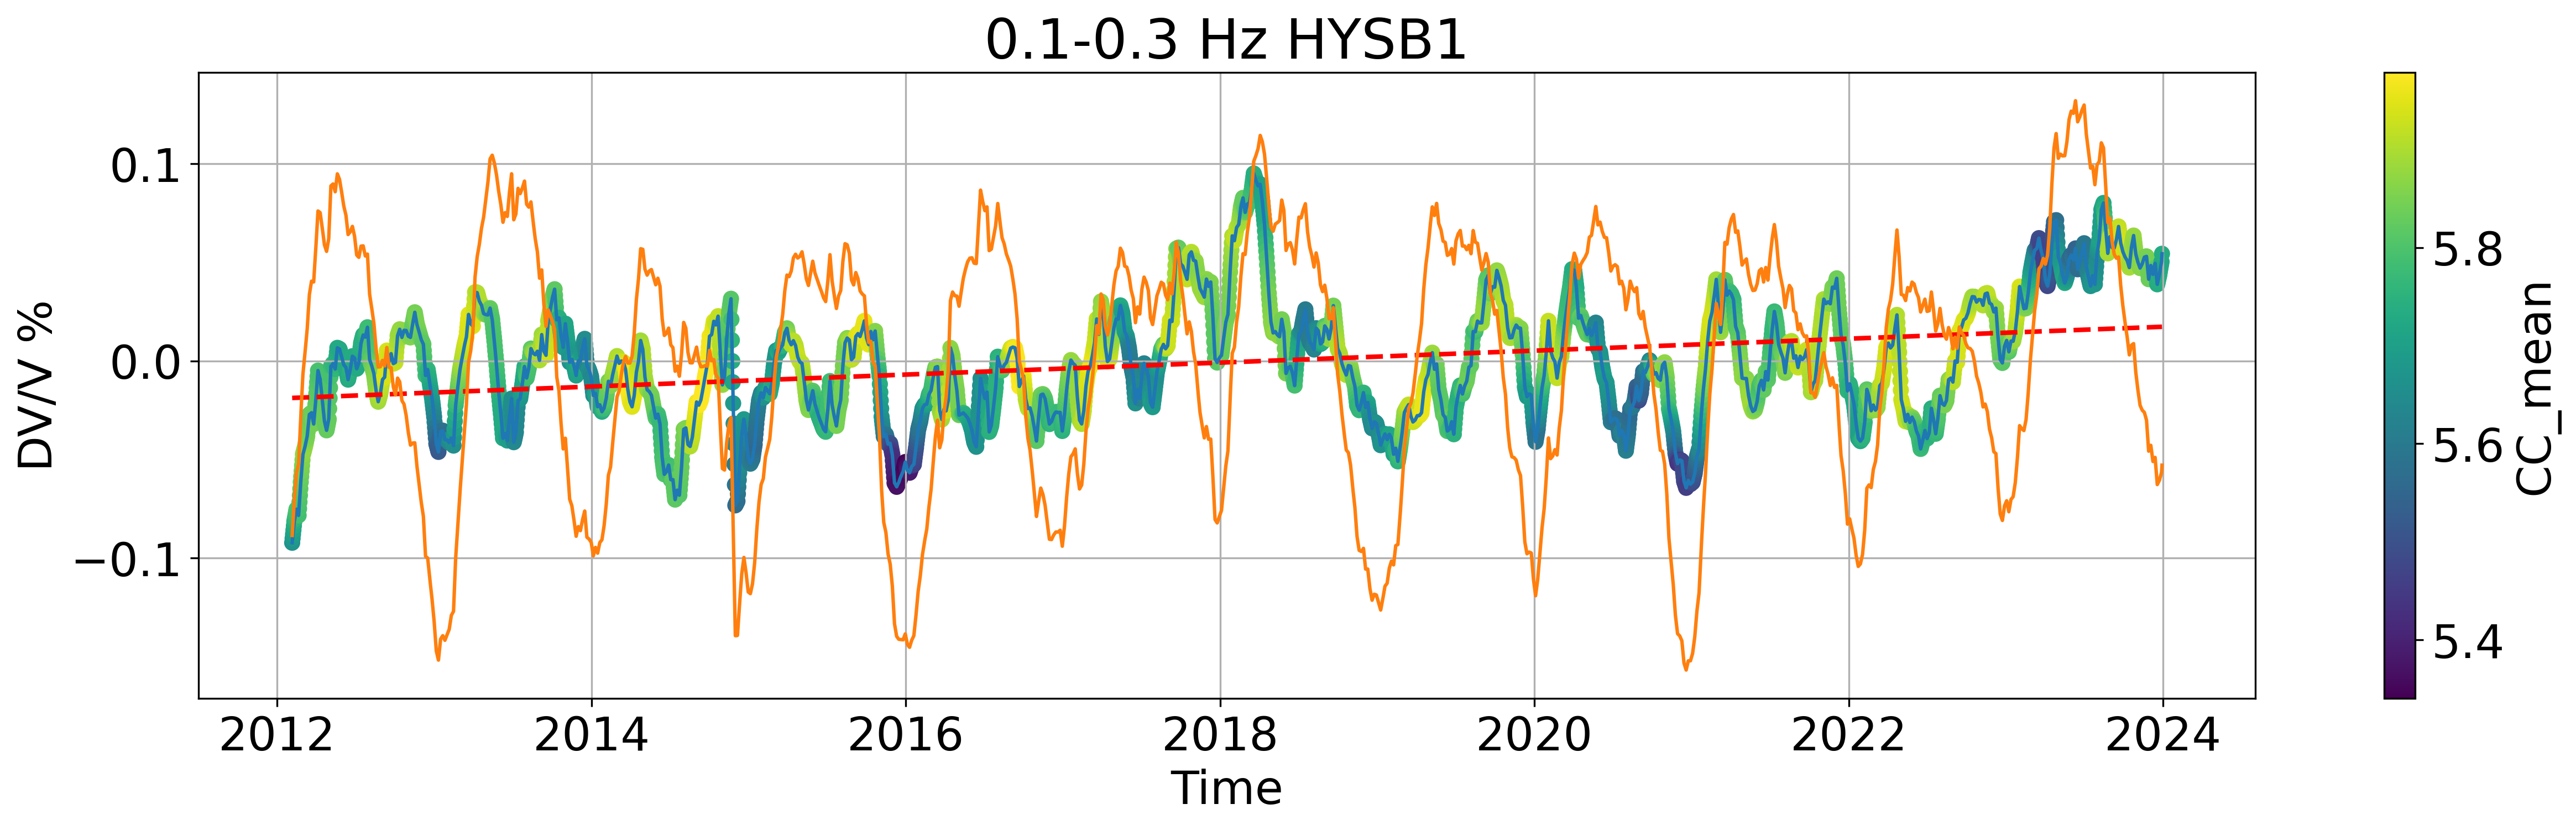

In [42]:
import numpy as np

# Convert the datetime index to a numerical value (e.g., using the ordinal value)
numerical_index = weighted_dvv_df.index.map(lambda x: x.toordinal())

# Fit a linear model to the filtered_dvt_values vs. numerical index
slope, intercept = np.polyfit(numerical_index, filtered_dvt_values, 1)

# Calculate the minimum and maximum of the linear fit
min_index = numerical_index.min()
max_index = numerical_index.max()

min_fit = slope * min_index + intercept
max_fit = slope * max_index + intercept

print(f"Minimum of linear fit: {min_fit}")
print(f"Maximum of linear fit: {max_fit}")

# Generate the fitted line values for plotting
fitted_line = slope * numerical_index + intercept

# Plot the original data along with the fitted line
plt.figure(figsize=(20, 5), dpi=300)

sc = plt.scatter(weighted_dvv_df.index, filtered_dvt_values, c=CC_mean, cmap=cmap, norm=norm)
plt.plot(weighted_dvv_df.index, filtered_dvt_values, label='Filtered Signal')
plt.plot(weighted_dvv_df.index, fitted_line, 'r--', linewidth=2, label='Fitted Line')  # Add red fitted line
plt.plot(weighted_dvv_df.index, dvt_values, label='Original Signal')
plt.colorbar(sc, label='CC_mean')
plt.xlabel('Time')
plt.ylabel('DV/V %')
plt.title('0.1-0.3 Hz HYSB1')
plt.grid(True)
plt.rcParams.update({'font.size': 20})
plt.show()


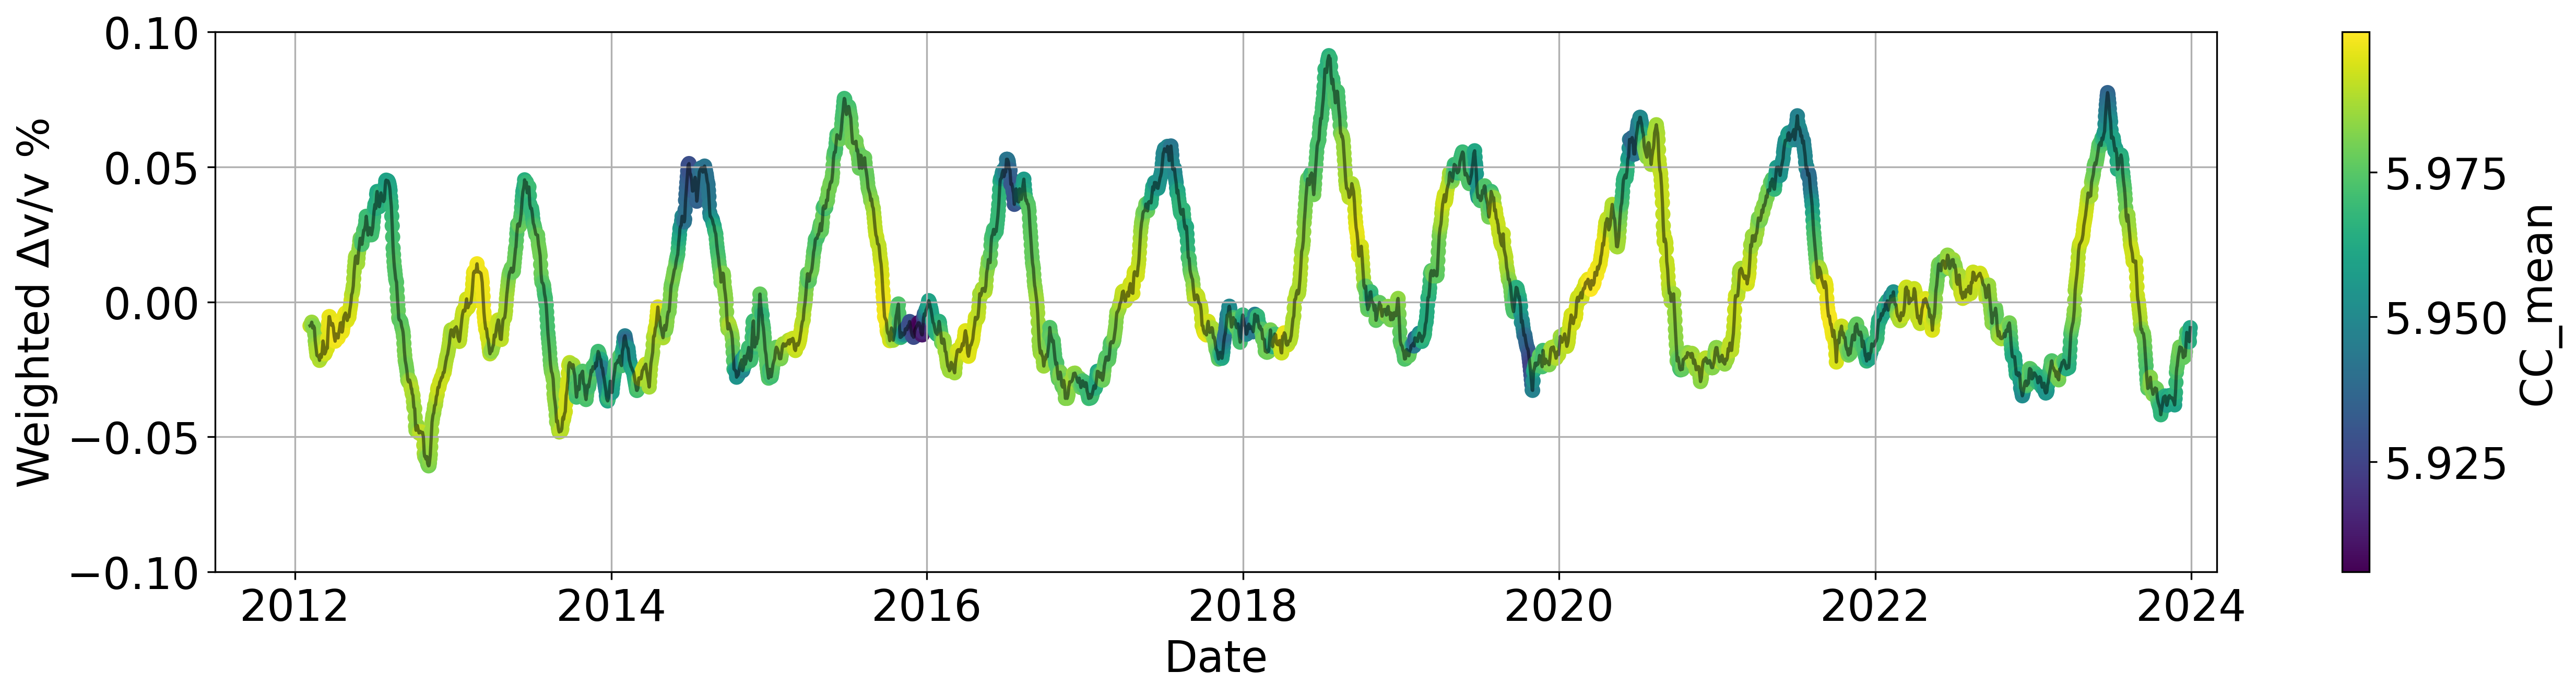

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd

# Define the paths to your CSV files
file_paths = [
    'NC89 Results/89_60daystack_0p3to0p6 positiveZN 630svd7.csv',
    'NC89 Results/89_60daystack_0p3to0p6 negativeZN 306svd7.csv',
    'NC89 Results/89_60daystack_0p3to0p6 positiveNE 630svd7.csv',
    'NC89 Results/89_60daystack_0p3to0p6 negativeNE 306svd7.csv',
    'NC89 Results/89_60daystack_0p3to0p6 positiveZE 630svd7.csv',
    'NC89 Results/89_60daystack_0p3to0p6 negativeZE 306svd7.csv',
]

dataframes = []
for path in file_paths:
    df = pd.read_csv(path)
    dataframes.append(df)

# Parse timestamps and set them as the index
for df in dataframes:
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)

# Create a unified daily time index spanning the full range of all dataframes
start_date = min(df.index.min() for df in dataframes)
end_date = max(df.index.max() for df in dataframes)
daily_index = pd.date_range(start=start_date, end=end_date, freq='D')

# Interpolate data for each dataframe to match the daily index
interpolated_dfs = [df.reindex(daily_index).interpolate() for df in dataframes]

# Define the date range to exclude
exclude_ranges = [
    (pd.to_datetime("2023-12-01"), pd.to_datetime("2024-01-30")),
    (pd.to_datetime("2009-11-10"), pd.to_datetime("2012-01-05"))
]

# Exclude the specified date ranges
for start_date, end_date in exclude_ranges:
    for i in range(len(interpolated_dfs)):
        interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)

# Calculate CC_mean using squared correlation coefficients for each time point
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)

# Calculate weighted Δu/u using squared CCT and DVT
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Normalize CC_mean for coloring
norm = mcolors.Normalize(vmin=CC_mean.min(), vmax=CC_mean.max())
cmap = cm.viridis  # Can choose any available colormap

# Create a DataFrame for the weighted Δv/v time series
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])

# Add a 30-day offset to the index
weighted_dvv_df.index = weighted_dvv_df.index + pd.DateOffset(days=30)

# Plotting the weighted Δv/v time series with color-coded CC_mean
plt.figure(figsize=(18, 5), dpi=300)
# Scatter plot for individual markers with color coding
sc = plt.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cmap, norm=norm, label='Weighted Δv/v')
# Line plot to connect markers
plt.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)  # Adjust alpha for line transparency
plt.colorbar(sc, label='CC_mean')

#plt.title('Weighted Δv/v For HYS14 1.0-3.0Hz Combined')
plt.xlabel('Date')
plt.ylim([-0.1, 0.1])
plt.ylabel('Weighted Δv/v %')
plt.grid(True)

# Set x-axis limits
plot_start_date = pd.to_datetime("2011-07-01")
plot_end_date = pd.to_datetime("2024-03-01")
plt.rcParams.update({'font.size': 25})
plt.xlim([plot_start_date, plot_end_date])
plt.xticks()
plt.tight_layout()
plt.show()


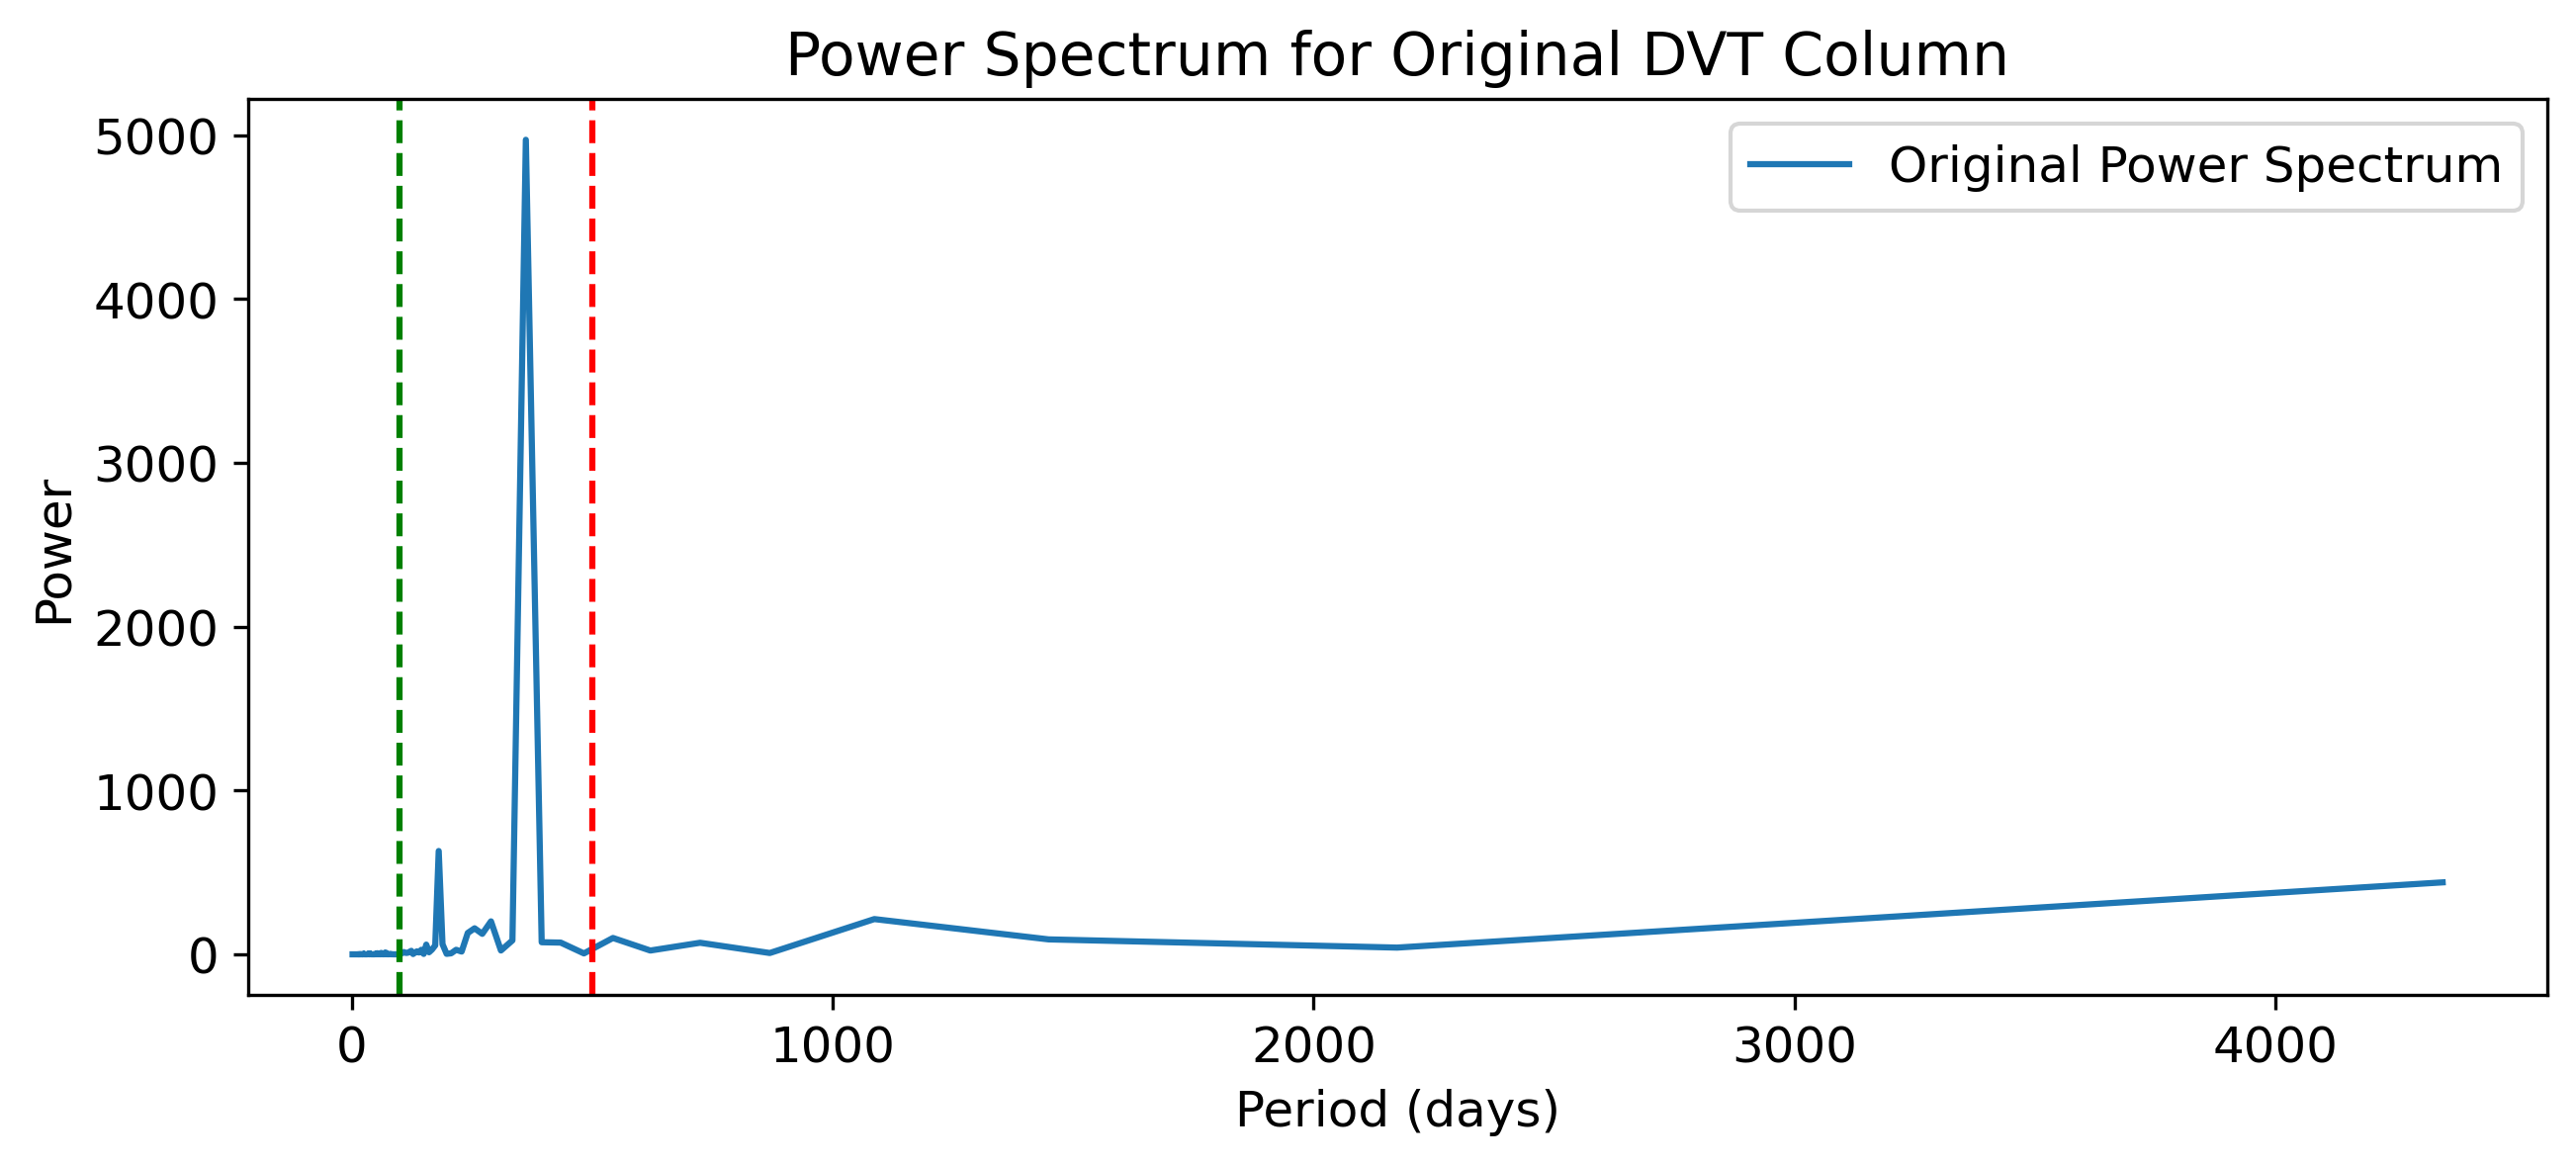

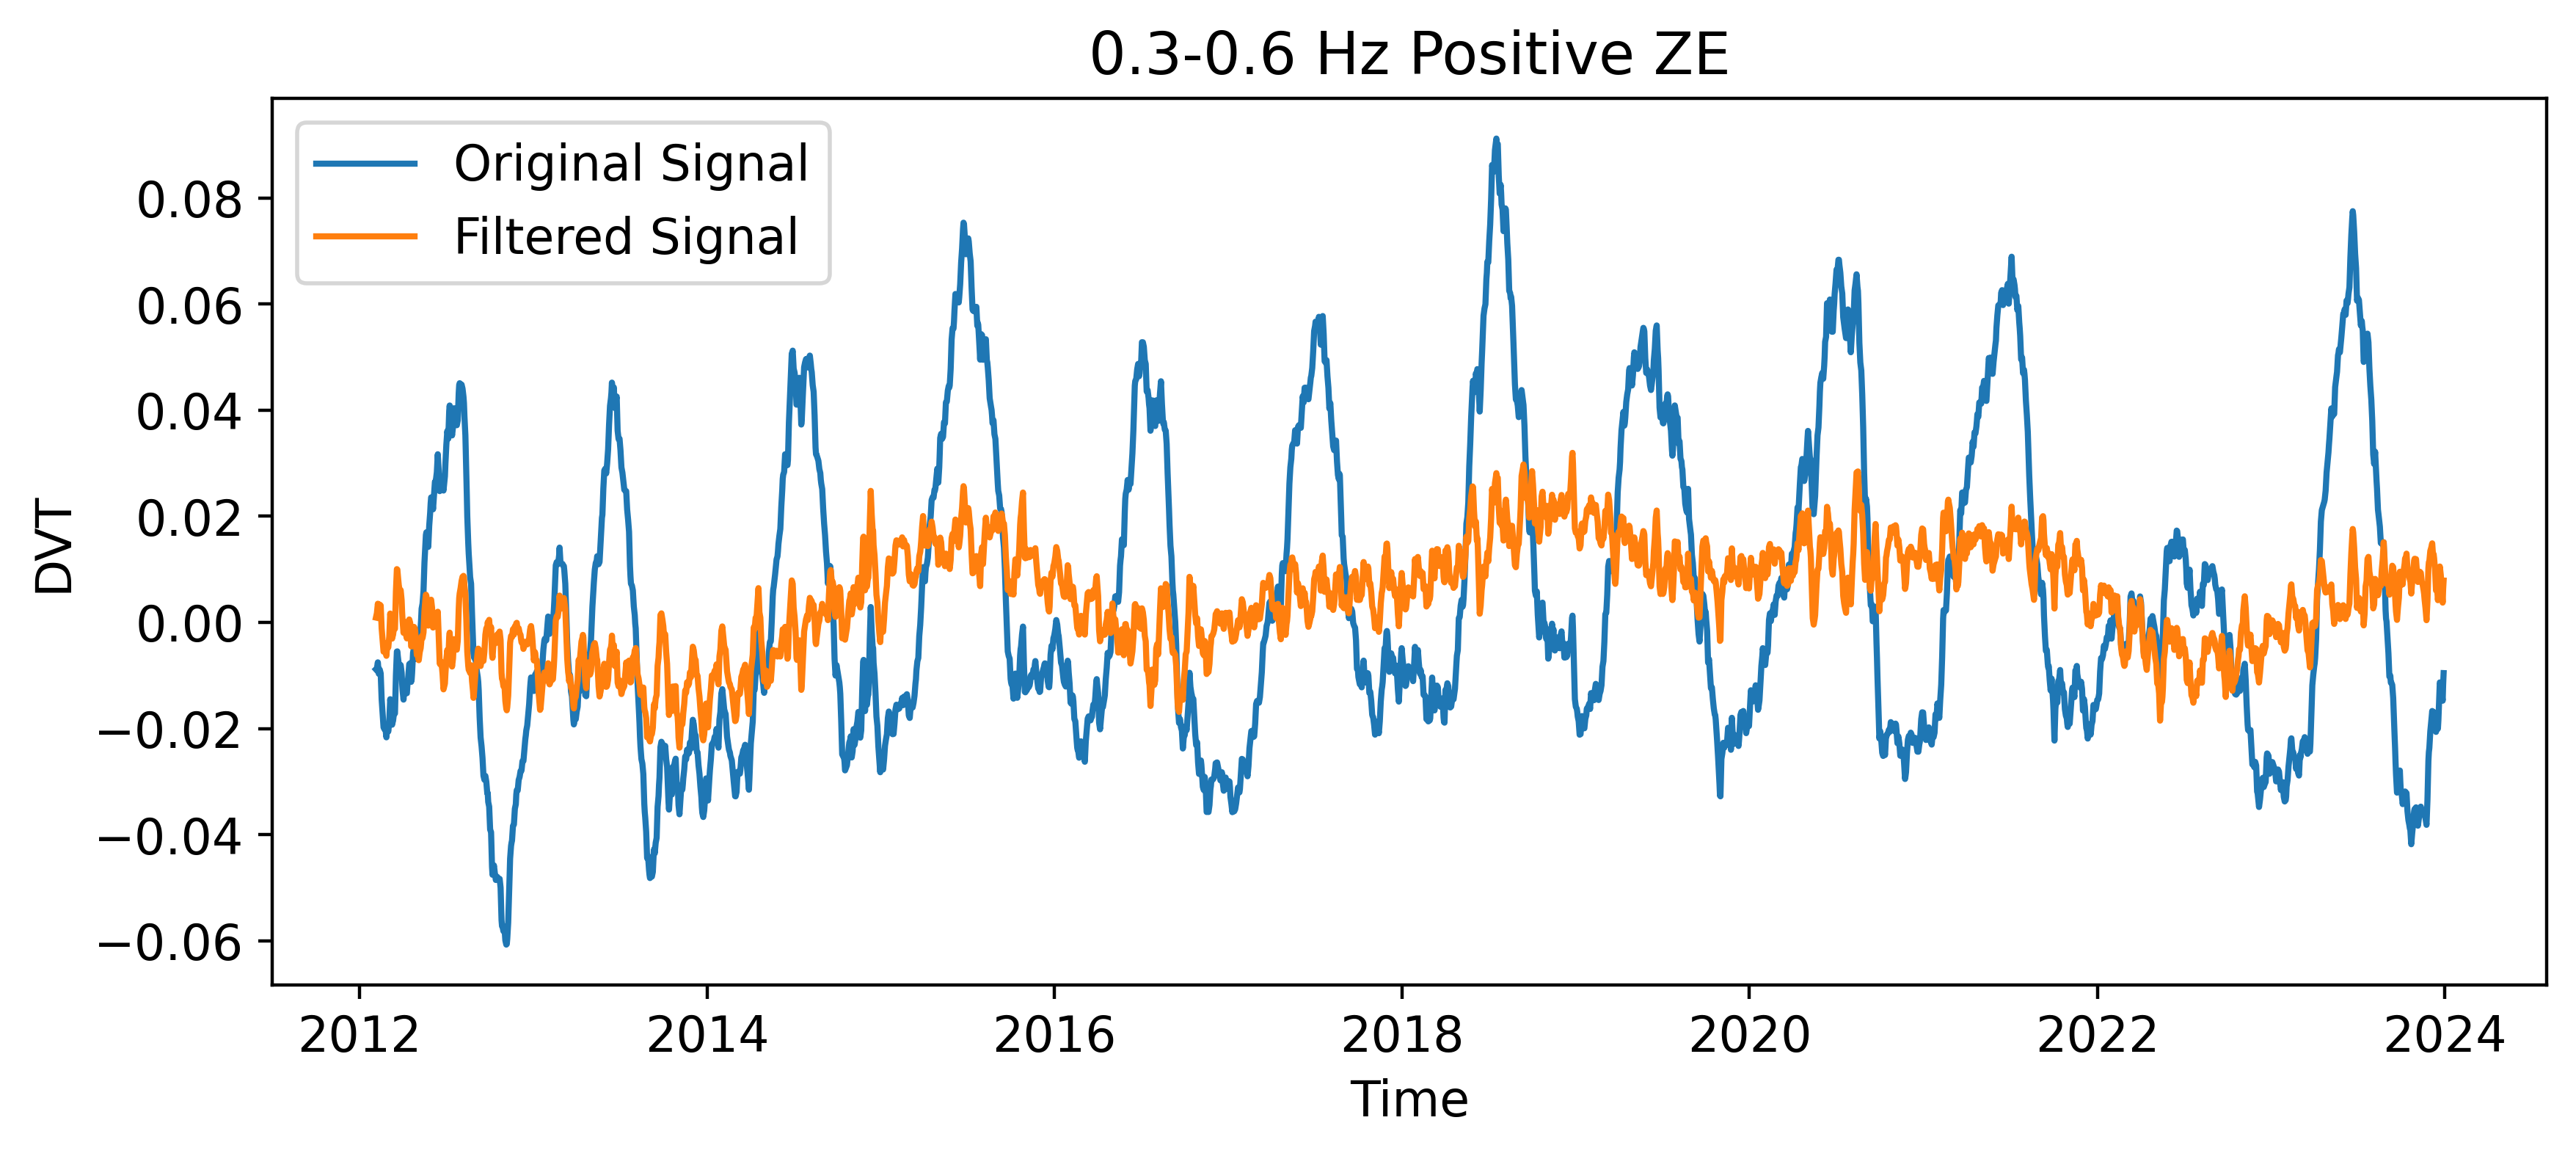

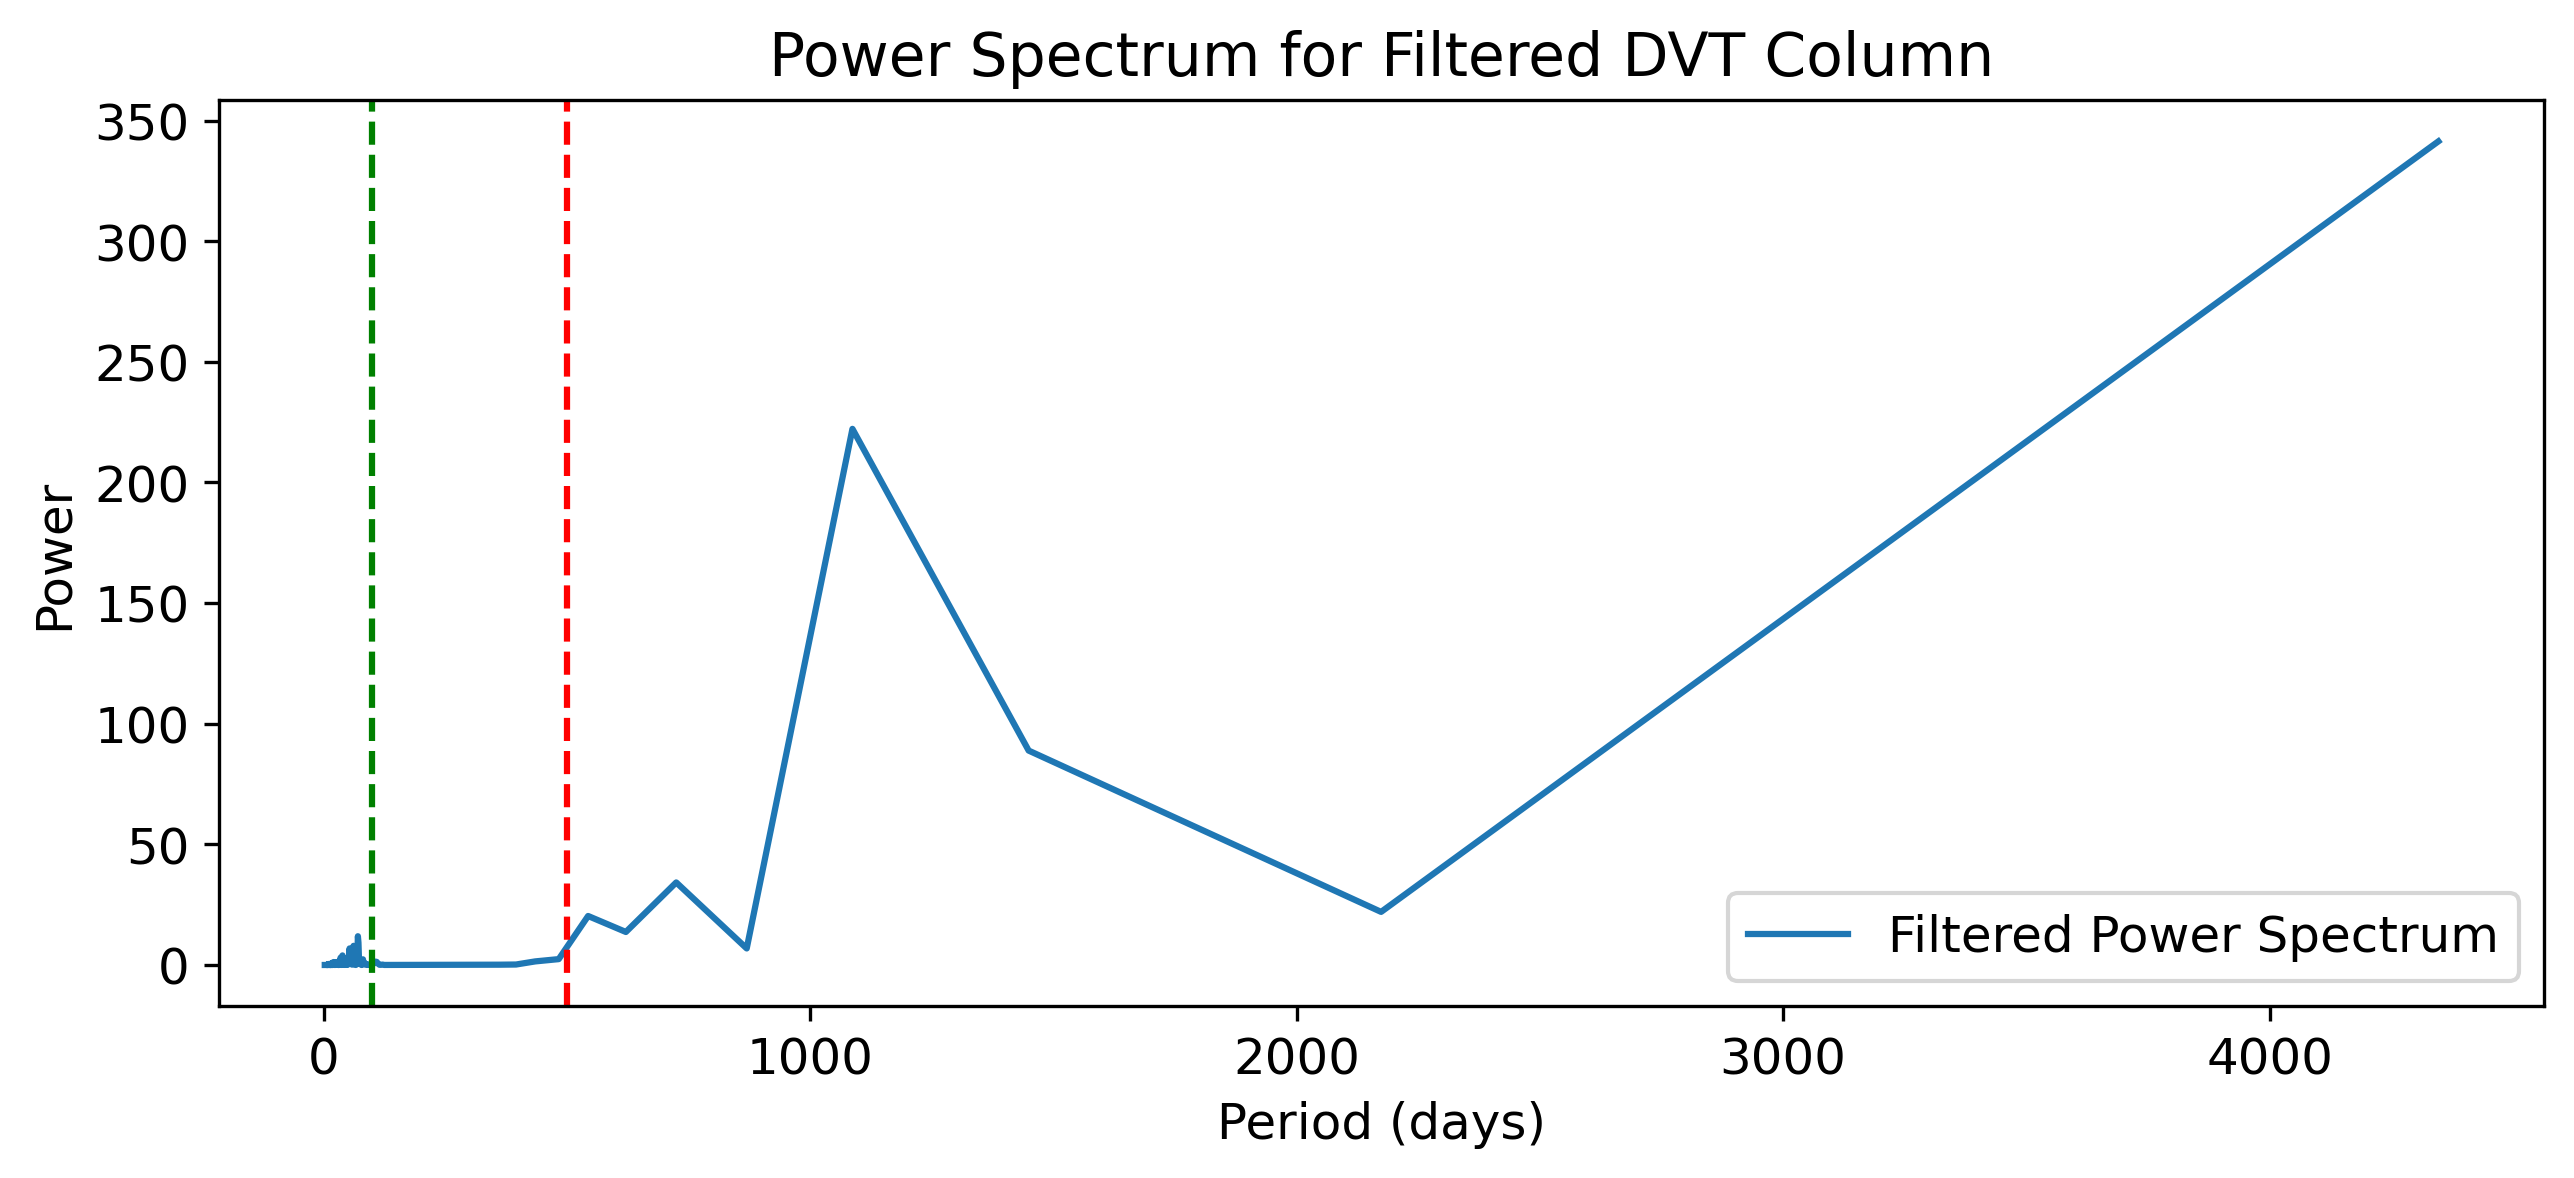

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

# Assuming weighted_dvv_df is already defined
# weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])

# Extract the 'Weighted Δv/v' column into a separate variable
dvt_values = weighted_dvv_df['Weighted Δv/v'].values

# Interpolate or fill NaNs in the signal
dvt_values_filled = pd.Series(dvt_values).interpolate().fillna(method='bfill').fillna(method='ffill').values

# Define the sample rate
samplingrate = 1  # Sample rate is 1 sample per day
fs = 1 / samplingrate

# Define the stop band
lowcut = 1 / 500  # 1/500 days
highcut = 1 / 100  # 1/180 days

# Design the band-stop filter
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='bandstop')

# Apply the band-stop filter to the signal
filtered_dvt_values = filtfilt(b, a, dvt_values_filled)

# Perform FFT on the original signal
n = len(dvt_values_filled)
dvt_fft = fft(dvt_values_filled)
frequencies = fftfreq(n, d=1/fs)
power_spectrum = np.abs(dvt_fft)**2

# Perform FFT on the filtered signal
filtered_dvt_fft = fft(filtered_dvt_values)
filtered_power_spectrum = np.abs(filtered_dvt_fft)**2

# Get the positive frequencies and power spectrum
positive_frequencies = frequencies[frequencies > 0]
positive_power_spectrum = power_spectrum[frequencies > 0]
filtered_positive_power_spectrum = filtered_power_spectrum[frequencies > 0]
plt.rcParams.update({'font.size': 12})
# Plot the power spectrum of the original signal
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(1/positive_frequencies, positive_power_spectrum, label='Original Power Spectrum')
plt.axvline(x=1/lowcut, color='r', linestyle='--')
plt.axvline(x=1/highcut, color='g', linestyle='--')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Power Spectrum for Original DVT Column')
plt.legend()
plt.show()

# Plot the original and filtered signals
plt.figure(figsize=(10, 4), dpi=400)
plt.plot(weighted_dvv_df.index, dvt_values, label='Original Signal')
plt.plot(weighted_dvv_df.index, filtered_dvt_values, label='Filtered Signal')
plt.xlabel('Time')
plt.ylabel('DVT')
plt.title('0.3-0.6 Hz Positive ZE')
plt.legend()
plt.show()

# Plot the power spectrum of the filtered signal
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(1/positive_frequencies, filtered_positive_power_spectrum, label='Filtered Power Spectrum')
plt.axvline(x=1/lowcut, color='r', linestyle='--')
plt.axvline(x=1/highcut, color='g', linestyle='--')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Power Spectrum for Filtered DVT Column')
plt.legend()
plt.show()


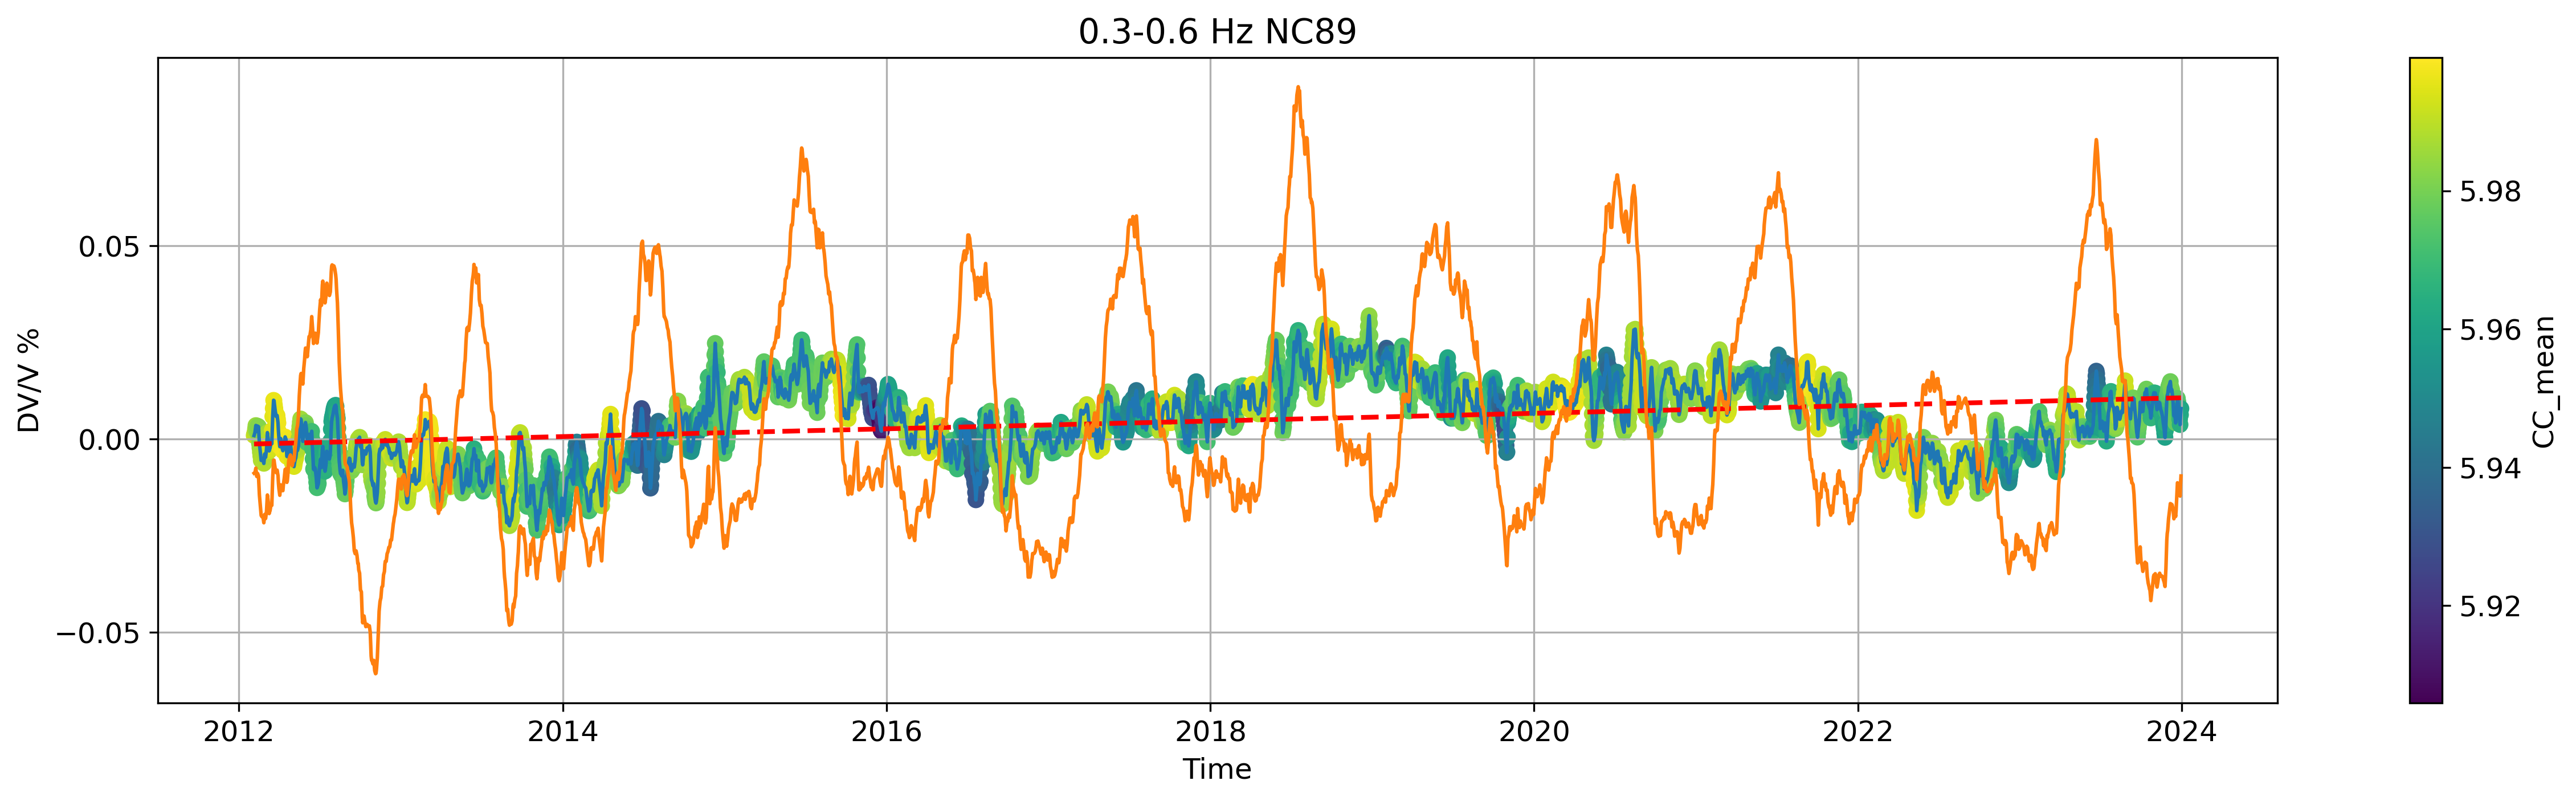

In [45]:
import numpy as np

# Convert the datetime index to a numerical value (e.g., using the ordinal value)
numerical_index = weighted_dvv_df.index.map(lambda x: x.toordinal())

# Fit a linear model to the filtered_dvt_values vs. numerical index
slope, intercept = np.polyfit(numerical_index, filtered_dvt_values, 1)

# Generate the fitted line values
fitted_line = slope * numerical_index + intercept

# Plot the original data along with the fitted line
plt.figure(figsize=(20, 5), dpi=300)
sc = plt.scatter(weighted_dvv_df.index, filtered_dvt_values, c=CC_mean, cmap=cmap, norm=norm)
plt.plot(weighted_dvv_df.index, filtered_dvt_values, label='Filtered Signal')
plt.plot(weighted_dvv_df.index, fitted_line, 'r--', linewidth=2, label='Fitted Line')  # Add red fitted line
plt.plot(weighted_dvv_df.index, dvt_values, label='Original Signal')
plt.colorbar(sc, label='CC_mean')
plt.xlabel('Time')
plt.ylabel('DV/V %')
plt.title('0.3-0.6 Hz NC89')
plt.grid(True)
plt.rcParams.update({'font.size': 20})
plt.show()
